In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
from collections import Counter
from matplotlib.lines import Line2D
import time
import optuna

np.random.seed(42)

C:\ProgramData\Anaconda3\envs\torchvision2\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
from uuu import mapk_plot, mapk, calculate_serendipity_per_user, prediction_coverage, \
catalog_coverage, long_tail_plot, weight_by_volume, get_frame_from_prediction_list, novelty, get_value_popularity_ranks

In [3]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df['UID'] = df['UID'] - 1
df['JID'] = df['JID'] - 1
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

df

df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)

E:\competitions\kaggle\magnit_recsys-in-practice\part2\uuu.py:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


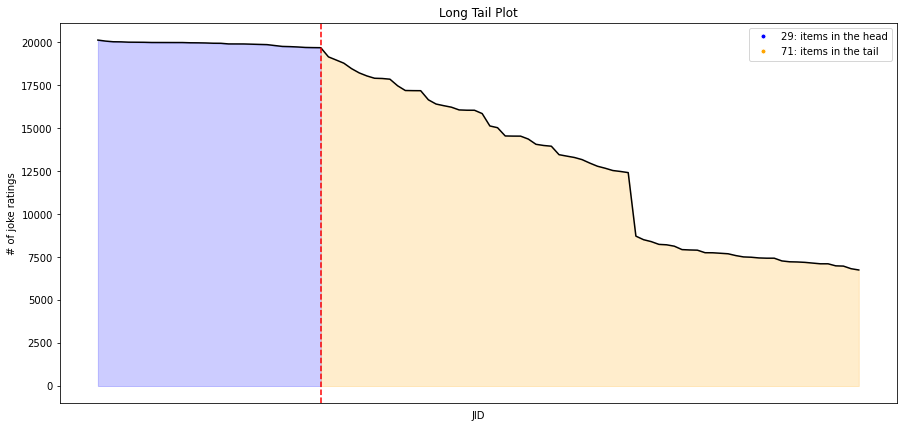

In [4]:
fig = plt.figure(figsize=(15, 7))
volume_df = long_tail_plot(df=df, 
             item_id_column="JID", 
             interaction_type="joke ratings", 
             percentage=0.4,
             x_labels=False)

volume_df['weight'] = volume_df['percent_of_total_volume'].apply(weight_by_volume)
joke_volume = {}
for row in volume_df.itertuples():
    joke_volume[int(row.JID)] = row.weight

In [5]:
df_top_joke = df[df['Rating'] > 5].groupby('JID').agg('count').rename(columns={'Rating':'count_plus'}) \
.sort_values('count_plus', ascending=False).drop(columns=['UID'])


df_bottom_joke = df[df['Rating'] < -5].groupby('JID').agg('count').rename(columns={'Rating':'count_minus'}) \
.sort_values('count_minus', ascending=False).drop(columns=['UID'])


df_counts = df_bottom_joke.merge(df_top_joke, left_index=True, right_index=True)


df_counts['diff'] = df_counts['count_plus'] - df_counts['count_minus']
df_counts = df_counts.sort_values('diff', ascending=False)


df_counts['weight'] = df_counts['diff'] / 10000

joke_quality = {}
for row in df_counts.itertuples():
    joke_quality[row.Index] = row.weight

In [6]:
with open('predictions_df_surprise.pkl', 'rb') as f:
    predictions_df_surprise = pickle.load(f)
    
predictions_df_surprise.keys()

dict_keys(['actual', 'svd', 'knn'])

In [7]:
with open('predictions_df_lfm.pkl', 'rb') as f:
    predictions_df_lfm = pickle.load(f)
    
predictions_df_lfm.keys()

dict_keys(['lfm', 'lfm_cos'])

In [8]:
with open('predictions_df_nn.pkl', 'rb') as f:
    predictions_df_nn = pickle.load(f)
    
predictions_df_nn.keys()

dict_keys(['nn'])

In [9]:
with open('predictions_df_catboost.pkl', 'rb') as f:
    predictions_df_catboost = pickle.load(f)
    
predictions_df_catboost.keys()

dict_keys(['catboost'])

In [10]:
with open('predictions_df_catboost_doc2vec.pkl', 'rb') as f:
    predictions_df_catboost_doc2vec = pickle.load(f)
    
predictions_df_catboost_doc2vec.keys()

dict_keys(['catboost_doc2vec'])

In [11]:
svd_df = predictions_df_surprise['svd']
knn_df = predictions_df_surprise['knn']
lfm_df = predictions_df_lfm['lfm']
lfm_cos_df = predictions_df_lfm['lfm_cos']
nn_df = predictions_df_nn['nn']
catboost_df = predictions_df_catboost['catboost']
catboost_doc2vec_df = predictions_df_catboost_doc2vec['catboost_doc2vec']
actual_df = predictions_df_surprise['actual']

In [12]:
frames = {'svd':svd_df, 'lfm':lfm_df, 'lfm_cos':lfm_cos_df, 'nn':nn_df, 
          'catboost':catboost_df, 'knn':knn_df, 'catboost_doc2vec':catboost_doc2vec_df}

predictions = {k:list(v.groupby('UID').agg({'JID':list})['JID'].values) for k, v in frames.items()}
actual = list(predictions_df_surprise['actual'].groupby('UID').agg({'JID':list})['JID'].values)

In [13]:
users = df["UID"].unique()
n_users = users.size
n_users

24983

In [14]:
# рекомендации по популярным 
#popularity_recs = df['JID'].value_counts().head(10).index.tolist()

#pop_recs = []
#for user in tqdm(range(n_users)):
#    pop_predictions = popularity_recs
#    pop_recs.append(pop_predictions)
    
    
#predictions['popular'] = pop_recs

In [15]:
pop = dict(df.JID.value_counts())

In [16]:
items = np.unique(df['JID'])
items

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [17]:
def union_predicts(params):
    result = []

    for u in range(24983):
        res = {}
        for i, (key, value) in enumerate(predictions.items()):
            rank = {x: params[key] * (10-j) for j, x in enumerate(value[u])}

            for k, v in rank.items():
                if k in res:
                    res[k] += v
                else:
                    res[k] = v
                    
        for k in res:
            res[k] += joke_quality[k] * params['quality']
            res[k] += joke_volume[k] * params['volume']

        result.append([x[0] for x in sorted(res.items(), key=lambda item: item[1], reverse=True)][:10])
        
    return result

In [18]:
def main_metric(params):
    t1 = time.time()
    result = union_predicts(params)
    res_df = get_frame_from_prediction_list(users, result)


    cat_coverage = catalog_coverage(result, items, 100)
    pred_coverage = prediction_coverage(result, items)
    nov, mselfinfo_list = novelty(result, pop, len(users), 10)

    res_df = get_frame_from_prediction_list(users, result)
    serendip = calculate_serendipity_per_user(res_df, df_train, df_test)
    map1 = mapk(actual, result, k=1)
    map10 = mapk(actual, result, k=10)
    
    sm = sum([cat_coverage / 100, pred_coverage / 100, nov, serendip * 4, map1 * 2, map10 * 2])
    print('time',round(time.time() - t1, 3), 
        'cat_cov',  round(cat_coverage, 3), 
         'cov', round(pred_coverage, 3),
         'nov', round(nov, 3),
         'ser', round(serendip, 3),
        'm1',  round(map1 , 3),
         'm10', round(map10, 3),
         'sum', round(sm, 3))
    return sm

In [19]:
def objective(trial):    
    
    params = {'svd': trial.suggest_float(name='svd', low=-2, high=2, step=0.1), 
              'lfm': trial.suggest_float(name='lfm', low=-2, high=2, step=0.1), 
              'lfm_cos': trial.suggest_float(name='lfm_cos', low=-2, high=2, step=0.1), 
              'nn': trial.suggest_float(name='nn', low=-2, high=2, step=0.1), 
              'catboost': trial.suggest_float(name='catboost', low=-2, high=2, step=0.1), 
              'knn': trial.suggest_float(name='knn', low=-2, high=2, step=0.1), 
              'catboost_doc2vec': trial.suggest_float(name='catboost_doc2vec', low=-2, high=2, step=0.1),
              'quality': trial.suggest_float(name='quality', low=-2, high=2, step=0.1),
              'volume': trial.suggest_float(name='volume', low=-2, high=2, step=0.1)
             }
    
    return main_metric(params)
    


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)


[I 2023-05-06 19:23:36,530] A new study created in memory with name: no-name-d24dd762-d5f6-4ed0-afb5-c741c4c69554
[I 2023-05-06 19:23:39,719] Trial 0 finished with value: 4.17817177395531 and parameters: {'svd': -1.2999999999999998, 'lfm': 1.2000000000000002, 'lfm_cos': -1.7, 'nn': 1.5, 'catboost': -1.1, 'knn': 1.8000000000000003, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.6, 'volume': -1.2999999999999998}. Best is trial 0 with value: 4.17817177395531.


time 3.187 cat_cov 76.0 cov 100.0 nov 0.674 ser 0.076 m1 0.274 m10 0.446 sum 4.178


[I 2023-05-06 19:23:42,669] Trial 1 finished with value: 4.141601802136432 and parameters: {'svd': 1.3000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 0.10000000000000009, 'nn': -0.5, 'catboost': 1.6, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.4, 'volume': 0.40000000000000036}. Best is trial 0 with value: 4.17817177395531.


time 2.947 cat_cov 79.0 cov 100.0 nov 0.772 ser 0.107 m1 0.228 m10 0.347 sum 4.142


[I 2023-05-06 19:23:46,167] Trial 2 finished with value: 4.722522557831052 and parameters: {'svd': 0.6000000000000001, 'lfm': 1.8000000000000003, 'lfm_cos': 0.6000000000000001, 'nn': -0.19999999999999996, 'catboost': -1.5, 'knn': 1.4000000000000004, 'catboost_doc2vec': 0.8000000000000003, 'quality': -0.09999999999999987, 'volume': 1.4000000000000004}. Best is trial 2 with value: 4.722522557831052.


time 3.495 cat_cov 95.0 cov 100.0 nov 0.636 ser 0.138 m1 0.34 m10 0.451 sum 4.723


[I 2023-05-06 19:23:49,271] Trial 3 finished with value: 4.819742334683017 and parameters: {'svd': 1.7000000000000002, 'lfm': -2.0, 'lfm_cos': 1.3000000000000003, 'nn': 0.10000000000000009, 'catboost': -0.19999999999999996, 'knn': -0.09999999999999987, 'catboost_doc2vec': 1.4000000000000004, 'quality': 2.0, 'volume': 1.0}. Best is trial 3 with value: 4.819742334683017.


time 3.101 cat_cov 86.0 cov 100.0 nov 0.854 ser 0.132 m1 0.341 m10 0.449 sum 4.82


[I 2023-05-06 19:23:52,357] Trial 4 finished with value: 4.871916240161352 and parameters: {'svd': 0.30000000000000027, 'lfm': -2.0, 'lfm_cos': 0.30000000000000027, 'nn': 0.7000000000000002, 'catboost': -1.4, 'knn': -0.09999999999999987, 'catboost_doc2vec': -1.2, 'quality': 0.0, 'volume': -1.5}. Best is trial 4 with value: 4.871916240161352.


time 3.083 cat_cov 93.0 cov 100.0 nov 0.986 ser 0.136 m1 0.284 m10 0.423 sum 4.872


[I 2023-05-06 19:23:55,364] Trial 5 finished with value: 3.7080689351330762 and parameters: {'svd': 1.3000000000000003, 'lfm': 0.8000000000000003, 'lfm_cos': -1.4, 'nn': -1.7, 'catboost': 1.7000000000000002, 'knn': -1.5, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.20000000000000018, 'volume': 1.2000000000000002}. Best is trial 4 with value: 4.871916240161352.


time 3.006 cat_cov 87.0 cov 100.0 nov 0.792 ser 0.115 m1 0.08 m10 0.212 sum 3.708


[I 2023-05-06 19:23:58,386] Trial 6 finished with value: 3.9971387505404694 and parameters: {'svd': 0.0, 'lfm': -1.2, 'lfm_cos': 0.6000000000000001, 'nn': 1.2000000000000002, 'catboost': 1.1, 'knn': 1.6, 'catboost_doc2vec': -0.19999999999999996, 'quality': -0.7999999999999998, 'volume': 1.7000000000000002}. Best is trial 4 with value: 4.871916240161352.


time 3.019 cat_cov 42.0 cov 95.0 nov 0.695 ser 0.088 m1 0.32 m10 0.471 sum 3.997


[I 2023-05-06 19:24:01,837] Trial 7 finished with value: 4.805142795893527 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.8000000000000003, 'lfm_cos': 0.20000000000000018, 'nn': -0.5999999999999999, 'catboost': 1.1, 'knn': -0.7, 'catboost_doc2vec': -0.7999999999999998, 'quality': 2.0, 'volume': -0.3999999999999999}. Best is trial 4 with value: 4.871916240161352.


time 3.448 cat_cov 96.0 cov 100.0 nov 0.671 ser 0.153 m1 0.334 m10 0.448 sum 4.805


[I 2023-05-06 19:24:05,268] Trial 8 finished with value: 4.121713080667014 and parameters: {'svd': -1.2999999999999998, 'lfm': 1.1, 'lfm_cos': -1.1, 'nn': 1.1, 'catboost': 0.40000000000000036, 'knn': -1.1, 'catboost_doc2vec': -0.8999999999999999, 'quality': -1.4, 'volume': 1.5}. Best is trial 4 with value: 4.871916240161352.


time 3.428 cat_cov 94.0 cov 100.0 nov 0.65 ser 0.119 m1 0.197 m10 0.332 sum 4.122


[I 2023-05-06 19:24:08,339] Trial 9 finished with value: 4.424423224923798 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.5, 'lfm_cos': -1.2999999999999998, 'nn': 1.7000000000000002, 'catboost': -0.8999999999999999, 'knn': 1.2000000000000002, 'catboost_doc2vec': -1.2, 'quality': 0.40000000000000036, 'volume': 0.8000000000000003}. Best is trial 4 with value: 4.871916240161352.


time 3.069 cat_cov 74.0 cov 100.0 nov 0.773 ser 0.089 m1 0.317 m10 0.461 sum 4.424


[I 2023-05-06 19:24:12,034] Trial 10 finished with value: 4.933554158348571 and parameters: {'svd': -0.2999999999999998, 'lfm': -0.2999999999999998, 'lfm_cos': 2.0, 'nn': 0.6000000000000001, 'catboost': -2.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.9, 'quality': 1.0, 'volume': -2.0}. Best is trial 10 with value: 4.933554158348571.


time 3.674 cat_cov 99.0 cov 100.0 nov 0.857 ser 0.201 m1 0.257 m10 0.384 sum 4.934


[I 2023-05-06 19:24:15,671] Trial 11 finished with value: 4.956113876884285 and parameters: {'svd': -0.2999999999999998, 'lfm': -0.09999999999999987, 'lfm_cos': 2.0, 'nn': 0.5, 'catboost': -1.6, 'knn': 0.40000000000000036, 'catboost_doc2vec': -2.0, 'quality': 0.8000000000000003, 'volume': -1.8}. Best is trial 11 with value: 4.956113876884285.


time 3.614 cat_cov 100.0 cov 100.0 nov 0.849 ser 0.203 m1 0.261 m10 0.387 sum 4.956


[I 2023-05-06 19:24:19,345] Trial 12 finished with value: 4.929248040997206 and parameters: {'svd': -0.7, 'lfm': -0.19999999999999996, 'lfm_cos': 2.0, 'nn': 0.5, 'catboost': -1.9, 'knn': 0.5, 'catboost_doc2vec': -2.0, 'quality': 1.0, 'volume': -1.9}. Best is trial 11 with value: 4.956113876884285.


time 3.652 cat_cov 99.0 cov 100.0 nov 0.86 ser 0.204 m1 0.251 m10 0.38 sum 4.929


[I 2023-05-06 19:24:23,076] Trial 13 finished with value: 4.988857003171591 and parameters: {'svd': -0.5, 'lfm': -0.19999999999999996, 'lfm_cos': 1.8000000000000003, 'nn': -1.1, 'catboost': -2.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.8, 'quality': 0.9000000000000004, 'volume': -0.7}. Best is trial 13 with value: 4.988857003171591.


time 3.708 cat_cov 100.0 cov 100.0 nov 0.933 ser 0.232 m1 0.209 m10 0.355 sum 4.989


[I 2023-05-06 19:24:26,865] Trial 14 finished with value: 4.796203679411514 and parameters: {'svd': -2.0, 'lfm': 0.40000000000000036, 'lfm_cos': 1.1, 'nn': -1.5, 'catboost': -0.5, 'knn': -0.5, 'catboost_doc2vec': -2.0, 'quality': 1.0, 'volume': -0.5999999999999999}. Best is trial 13 with value: 4.988857003171591.


time 3.765 cat_cov 98.0 cov 100.0 nov 0.845 ser 0.222 m1 0.2 m10 0.342 sum 4.796


[I 2023-05-06 19:24:30,717] Trial 15 finished with value: 4.7324666118766805 and parameters: {'svd': -0.7, 'lfm': -0.7, 'lfm_cos': 1.4000000000000004, 'nn': -1.2, 'catboost': -2.0, 'knn': -2.0, 'catboost_doc2vec': -1.5, 'quality': -0.5999999999999999, 'volume': -0.8999999999999999}. Best is trial 13 with value: 4.988857003171591.


time 3.829 cat_cov 90.0 cov 100.0 nov 0.949 ser 0.233 m1 0.16 m10 0.314 sum 4.732


[I 2023-05-06 19:24:33,817] Trial 16 finished with value: 4.667463671752772 and parameters: {'svd': 0.7000000000000002, 'lfm': 0.30000000000000027, 'lfm_cos': -0.5999999999999999, 'nn': -0.7999999999999998, 'catboost': -0.7, 'knn': 0.9000000000000004, 'catboost_doc2vec': -1.5, 'quality': 0.6000000000000001, 'volume': -0.09999999999999987}. Best is trial 13 with value: 4.988857003171591.


time 3.076 cat_cov 88.0 cov 100.0 nov 0.827 ser 0.106 m1 0.317 m10 0.451 sum 4.667


[I 2023-05-06 19:24:37,463] Trial 17 finished with value: 4.8458523567584795 and parameters: {'svd': -0.5, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': -2.0, 'catboost': 0.30000000000000027, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5999999999999999, 'quality': 1.4000000000000004, 'volume': -1.1}. Best is trial 13 with value: 4.988857003171591.


time 3.623 cat_cov 100.0 cov 100.0 nov 0.909 ser 0.227 m1 0.184 m10 0.331 sum 4.846


[I 2023-05-06 19:24:40,896] Trial 18 finished with value: 4.343157028613318 and parameters: {'svd': -1.2999999999999998, 'lfm': 0.20000000000000018, 'lfm_cos': 0.9000000000000004, 'nn': 0.10000000000000009, 'catboost': -1.4, 'knn': 1.0, 'catboost_doc2vec': 1.9000000000000004, 'quality': -1.9, 'volume': -1.5}. Best is trial 13 with value: 4.988857003171591.


time 3.412 cat_cov 98.0 cov 100.0 nov 0.824 ser 0.162 m1 0.144 m10 0.301 sum 4.343


[I 2023-05-06 19:24:44,745] Trial 19 finished with value: 4.835530579371785 and parameters: {'svd': -1.0, 'lfm': 0.7000000000000002, 'lfm_cos': 1.7000000000000002, 'nn': -1.1, 'catboost': -1.6, 'knn': -0.5, 'catboost_doc2vec': -1.5, 'quality': 0.7000000000000002, 'volume': 0.30000000000000027}. Best is trial 13 with value: 4.988857003171591.


time 3.825 cat_cov 98.0 cov 100.0 nov 0.824 ser 0.227 m1 0.21 m10 0.353 sum 4.836


[I 2023-05-06 19:24:47,818] Trial 20 finished with value: 4.143148516467269 and parameters: {'svd': -0.19999999999999996, 'lfm': -0.19999999999999996, 'lfm_cos': -0.3999999999999999, 'nn': 2.0, 'catboost': -1.1, 'knn': 0.6000000000000001, 'catboost_doc2vec': 1.0, 'quality': 1.4000000000000004, 'volume': -0.7999999999999998}. Best is trial 13 with value: 4.988857003171591.


time 3.049 cat_cov 61.0 cov 99.0 nov 0.678 ser 0.078 m1 0.314 m10 0.462 sum 4.143


[I 2023-05-06 19:24:51,480] Trial 21 finished with value: 4.922413039107846 and parameters: {'svd': -0.19999999999999996, 'lfm': -0.2999999999999998, 'lfm_cos': 2.0, 'nn': 0.6000000000000001, 'catboost': -2.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': 1.0, 'volume': -2.0}. Best is trial 13 with value: 4.988857003171591.


time 3.639 cat_cov 97.0 cov 100.0 nov 0.858 ser 0.203 m1 0.257 m10 0.384 sum 4.922


[I 2023-05-06 19:24:55,166] Trial 22 finished with value: 4.991594660382856 and parameters: {'svd': 0.10000000000000009, 'lfm': -0.3999999999999999, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.7, 'knn': -0.19999999999999996, 'catboost_doc2vec': -1.7, 'quality': 0.8000000000000003, 'volume': -1.7}. Best is trial 22 with value: 4.991594660382856.


time 3.663 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.221 m1 0.24 m10 0.374 sum 4.992


[I 2023-05-06 19:24:58,905] Trial 23 finished with value: 4.9334108702388635 and parameters: {'svd': 0.30000000000000027, 'lfm': -1.2, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'catboost': -1.6, 'knn': 0.0, 'catboost_doc2vec': -1.5, 'quality': 0.7000000000000002, 'volume': -1.6}. Best is trial 22 with value: 4.991594660382856.


time 3.717 cat_cov 100.0 cov 100.0 nov 0.987 ser 0.219 m1 0.185 m10 0.349 sum 4.933


[I 2023-05-06 19:25:02,449] Trial 24 finished with value: 4.95737891292552 and parameters: {'svd': 0.30000000000000027, 'lfm': 0.10000000000000009, 'lfm_cos': 1.0, 'nn': 1.0, 'catboost': -0.3999999999999999, 'knn': -0.2999999999999998, 'catboost_doc2vec': -1.1, 'quality': -0.2999999999999998, 'volume': -1.1}. Best is trial 22 with value: 4.991594660382856.


time 3.521 cat_cov 100.0 cov 100.0 nov 0.795 ser 0.175 m1 0.305 m10 0.425 sum 4.957


[I 2023-05-06 19:25:05,951] Trial 25 finished with value: 4.986780764833819 and parameters: {'svd': 0.9000000000000004, 'lfm': 0.6000000000000001, 'lfm_cos': 0.9000000000000004, 'nn': 1.0, 'catboost': -0.2999999999999998, 'knn': -1.0, 'catboost_doc2vec': -1.1, 'quality': -0.3999999999999999, 'volume': -0.3999999999999999}. Best is trial 22 with value: 4.991594660382856.


time 3.48 cat_cov 100.0 cov 100.0 nov 0.783 ser 0.183 m1 0.304 m10 0.432 sum 4.987


[I 2023-05-06 19:25:09,535] Trial 26 finished with value: 4.98224661835761 and parameters: {'svd': 0.9000000000000004, 'lfm': 0.6000000000000001, 'lfm_cos': 0.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 0.10000000000000009, 'knn': -1.1, 'catboost_doc2vec': -0.5, 'quality': -0.5999999999999999, 'volume': -0.3999999999999999}. Best is trial 22 with value: 4.991594660382856.


time 3.561 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.201 m1 0.277 m10 0.408 sum 4.982


[I 2023-05-06 19:25:13,145] Trial 27 finished with value: 4.911055892909443 and parameters: {'svd': 1.1, 'lfm': 1.3000000000000003, 'lfm_cos': 1.3000000000000003, 'nn': -0.2999999999999998, 'catboost': 0.8000000000000003, 'knn': -0.8999999999999999, 'catboost_doc2vec': -1.7, 'quality': 0.30000000000000027, 'volume': 0.0}. Best is trial 22 with value: 4.991594660382856.


time 3.588 cat_cov 99.0 cov 100.0 nov 0.767 ser 0.199 m1 0.272 m10 0.407 sum 4.911


[I 2023-05-06 19:25:16,804] Trial 28 finished with value: 4.973378854530963 and parameters: {'svd': 0.5, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.9000000000000004, 'catboost': -1.1, 'knn': -1.4, 'catboost_doc2vec': -1.0, 'quality': -1.0, 'volume': -0.19999999999999996}. Best is trial 22 with value: 4.991594660382856.


time 3.636 cat_cov 99.0 cov 100.0 nov 0.934 ser 0.226 m1 0.214 m10 0.357 sum 4.973


[I 2023-05-06 19:25:20,368] Trial 29 finished with value: 4.736299437078095 and parameters: {'svd': -1.7, 'lfm': 1.3000000000000003, 'lfm_cos': 1.3000000000000003, 'nn': 1.4000000000000004, 'catboost': -0.8999999999999999, 'knn': 1.8000000000000003, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.4000000000000004, 'volume': 0.40000000000000036}. Best is trial 22 with value: 4.991594660382856.


time 3.541 cat_cov 98.0 cov 100.0 nov 0.674 ser 0.138 m1 0.322 m10 0.442 sum 4.736


[I 2023-05-06 19:25:23,935] Trial 30 finished with value: 4.421689422583477 and parameters: {'svd': 0.10000000000000009, 'lfm': 1.0, 'lfm_cos': -0.3999999999999999, 'nn': 1.6, 'catboost': -0.19999999999999996, 'knn': -1.8, 'catboost_doc2vec': -1.7, 'quality': -0.2999999999999998, 'volume': 2.0}. Best is trial 22 with value: 4.991594660382856.


time 3.545 cat_cov 93.0 cov 100.0 nov 0.605 ser 0.141 m1 0.264 m10 0.398 sum 4.422


[I 2023-05-06 19:25:27,527] Trial 31 finished with value: 4.958539700007895 and parameters: {'svd': 0.8000000000000003, 'lfm': 0.6000000000000001, 'lfm_cos': 0.7000000000000002, 'nn': 0.30000000000000027, 'catboost': 0.10000000000000009, 'knn': -1.2, 'catboost_doc2vec': -0.5, 'quality': -0.5999999999999999, 'volume': -0.3999999999999999}. Best is trial 22 with value: 4.991594660382856.


time 3.57 cat_cov 100.0 cov 100.0 nov 0.807 ser 0.204 m1 0.266 m10 0.402 sum 4.959


[I 2023-05-06 19:25:30,722] Trial 32 finished with value: 3.9419621183054008 and parameters: {'svd': 0.9000000000000004, 'lfm': 0.5, 'lfm_cos': 0.40000000000000036, 'nn': 0.30000000000000027, 'catboost': 2.0, 'knn': -0.8999999999999999, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.1, 'volume': -0.7}. Best is trial 22 with value: 4.991594660382856.


time 3.173 cat_cov 84.0 cov 100.0 nov 0.715 ser 0.133 m1 0.142 m10 0.285 sum 3.942


[I 2023-05-06 19:25:33,838] Trial 33 finished with value: 4.552765451021259 and parameters: {'svd': 1.2000000000000002, 'lfm': 0.10000000000000009, 'lfm_cos': -0.19999999999999996, 'nn': -0.5999999999999999, 'catboost': 0.6000000000000001, 'knn': -1.6, 'catboost_doc2vec': -1.2999999999999998, 'quality': -0.2999999999999998, 'volume': 0.10000000000000009}. Best is trial 22 with value: 4.991594660382856.


time 3.092 cat_cov 97.0 cov 100.0 nov 0.823 ser 0.133 m1 0.25 m10 0.365 sum 4.553


[I 2023-05-06 19:25:37,411] Trial 34 finished with value: 5.026632276488448 and parameters: {'svd': 1.5, 'lfm': 0.8000000000000003, 'lfm_cos': 0.7000000000000002, 'nn': 0.8000000000000003, 'catboost': 0.0, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': 0.10000000000000009, 'volume': 0.7000000000000002}. Best is trial 34 with value: 5.026632276488448.


time 3.55 cat_cov 96.0 cov 100.0 nov 0.696 ser 0.146 m1 0.398 m10 0.496 sum 5.027


[I 2023-05-06 19:25:40,861] Trial 35 finished with value: 5.046895736058887 and parameters: {'svd': 1.5, 'lfm': 0.9000000000000004, 'lfm_cos': 1.0, 'nn': 0.8000000000000003, 'catboost': -0.19999999999999996, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.10000000000000009, 'volume': 0.6000000000000001}. Best is trial 35 with value: 5.046895736058887.


time 3.427 cat_cov 99.0 cov 100.0 nov 0.71 ser 0.156 m1 0.379 m10 0.482 sum 5.047


[I 2023-05-06 19:25:44,366] Trial 36 finished with value: 5.03970524742297 and parameters: {'svd': 1.6, 'lfm': 0.9000000000000004, 'lfm_cos': 1.7000000000000002, 'nn': 0.8000000000000003, 'catboost': -0.7, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.5, 'quality': 0.0, 'volume': 1.0}. Best is trial 35 with value: 5.046895736058887.


time 3.483 cat_cov 100.0 cov 100.0 nov 0.753 ser 0.175 m1 0.338 m10 0.456 sum 5.04


[I 2023-05-06 19:25:47,903] Trial 37 finished with value: 4.865898287739361 and parameters: {'svd': 1.5, 'lfm': 1.7000000000000002, 'lfm_cos': 1.2000000000000002, 'nn': 0.8000000000000003, 'catboost': -0.5999999999999999, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.5, 'quality': 0.0, 'volume': 0.8000000000000003}. Best is trial 35 with value: 5.046895736058887.


time 3.515 cat_cov 99.0 cov 100.0 nov 0.674 ser 0.159 m1 0.333 m10 0.45 sum 4.866


[I 2023-05-06 19:25:51,424] Trial 38 finished with value: 4.977385132765768 and parameters: {'svd': 2.0, 'lfm': 1.5, 'lfm_cos': 1.5, 'nn': 1.4000000000000004, 'catboost': -0.09999999999999987, 'knn': 0.0, 'catboost_doc2vec': 0.7000000000000002, 'quality': 0.10000000000000009, 'volume': 0.6000000000000001}. Best is trial 35 with value: 5.046895736058887.


time 3.497 cat_cov 96.0 cov 100.0 nov 0.678 ser 0.148 m1 0.387 m10 0.487 sum 4.977


[I 2023-05-06 19:25:54,944] Trial 39 finished with value: 4.888362041764206 and parameters: {'svd': 1.5, 'lfm': 1.0, 'lfm_cos': 0.5, 'nn': -0.2999999999999998, 'catboost': 0.30000000000000027, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.40000000000000036, 'volume': 0.9000000000000004}. Best is trial 35 with value: 5.046895736058887.


time 3.496 cat_cov 98.0 cov 100.0 nov 0.699 ser 0.162 m1 0.334 m10 0.446 sum 4.888


[I 2023-05-06 19:25:58,035] Trial 40 finished with value: 4.6048502852340985 and parameters: {'svd': 1.6, 'lfm': 0.9000000000000004, 'lfm_cos': -1.8, 'nn': 1.2000000000000002, 'catboost': -0.7999999999999998, 'knn': -0.2999999999999998, 'catboost_doc2vec': 1.2000000000000002, 'quality': -0.09999999999999987, 'volume': 1.2000000000000002}. Best is trial 35 with value: 5.046895736058887.


time 3.067 cat_cov 83.0 cov 100.0 nov 0.73 ser 0.094 m1 0.358 m10 0.477 sum 4.605


[I 2023-05-06 19:26:01,313] Trial 41 finished with value: 5.164231282644348 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.8000000000000003, 'catboost': -1.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.5, 'volume': 0.5}. Best is trial 41 with value: 5.164231282644348.


time 3.256 cat_cov 97.0 cov 100.0 nov 0.853 ser 0.162 m1 0.367 m10 0.481 sum 5.164


[I 2023-05-06 19:26:04,740] Trial 42 finished with value: 5.208481958122053 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.8000000000000003, 'catboost': -1.2, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.20000000000000018, 'volume': 0.6000000000000001}. Best is trial 42 with value: 5.208481958122053.


time 3.404 cat_cov 99.0 cov 100.0 nov 0.861 ser 0.17 m1 0.364 m10 0.475 sum 5.208


[I 2023-05-06 19:26:08,020] Trial 43 finished with value: 5.104758791461548 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.8000000000000003, 'catboost': -1.2999999999999998, 'knn': -0.7, 'catboost_doc2vec': 0.40000000000000036, 'quality': 0.5, 'volume': 0.6000000000000001}. Best is trial 42 with value: 5.208481958122053.


time 3.254 cat_cov 94.0 cov 100.0 nov 0.934 ser 0.172 m1 0.326 m10 0.445 sum 5.105


[I 2023-05-06 19:26:11,275] Trial 44 finished with value: 5.097118487398342 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.4, 'lfm_cos': 1.8000000000000003, 'nn': 1.2000000000000002, 'catboost': -1.2999999999999998, 'knn': -0.7, 'catboost_doc2vec': 0.40000000000000036, 'quality': 0.40000000000000036, 'volume': 1.1}. Best is trial 42 with value: 5.208481958122053.


time 3.231 cat_cov 92.0 cov 100.0 nov 0.896 ser 0.165 m1 0.349 m10 0.463 sum 5.097


[I 2023-05-06 19:26:14,510] Trial 45 finished with value: 4.949669006543579 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.7, 'lfm_cos': 1.8000000000000003, 'nn': 1.3000000000000003, 'catboost': -1.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.5, 'volume': 0.40000000000000036}. Best is trial 42 with value: 5.208481958122053.


time 3.211 cat_cov 88.0 cov 100.0 nov 0.864 ser 0.141 m1 0.348 m10 0.473 sum 4.95


[I 2023-05-06 19:26:17,714] Trial 46 finished with value: 4.939842100282474 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.4000000000000004, 'nn': 1.6, 'catboost': -1.2, 'knn': -0.7, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.30000000000000027, 'volume': 1.1}. Best is trial 42 with value: 5.208481958122053.


time 3.18 cat_cov 87.0 cov 100.0 nov 0.858 ser 0.14 m1 0.351 m10 0.475 sum 4.94


[I 2023-05-06 19:26:21,181] Trial 47 finished with value: 5.008401610952475 and parameters: {'svd': 1.3000000000000003, 'lfm': -1.5, 'lfm_cos': 1.8000000000000003, 'nn': 1.9000000000000004, 'catboost': -1.0, 'knn': -0.7999999999999998, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.5, 'volume': 1.4000000000000004}. Best is trial 42 with value: 5.208481958122053.


time 3.442 cat_cov 93.0 cov 100.0 nov 0.858 ser 0.151 m1 0.345 m10 0.463 sum 5.008


[I 2023-05-06 19:26:24,479] Trial 48 finished with value: 5.113833574992113 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.5, 'nn': 0.6000000000000001, 'catboost': -1.8, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.7000000000000002, 'quality': 0.20000000000000018, 'volume': 0.6000000000000001}. Best is trial 42 with value: 5.208481958122053.


time 3.274 cat_cov 99.0 cov 100.0 nov 0.931 ser 0.184 m1 0.301 m10 0.428 sum 5.114


[I 2023-05-06 19:26:27,877] Trial 49 finished with value: 5.160410458645883 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 1.1, 'catboost': -1.8, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.8000000000000003, 'quality': -0.09999999999999987, 'volume': 0.20000000000000018}. Best is trial 42 with value: 5.208481958122053.


time 3.373 cat_cov 100.0 cov 100.0 nov 0.895 ser 0.184 m1 0.323 m10 0.442 sum 5.16


[I 2023-05-06 19:26:31,373] Trial 50 finished with value: 4.998614520842286 and parameters: {'svd': 1.3000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.5, 'nn': 0.6000000000000001, 'catboost': -1.8, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.8000000000000003, 'quality': 0.20000000000000018, 'volume': 0.20000000000000018}. Best is trial 42 with value: 5.208481958122053.


time 3.472 cat_cov 100.0 cov 100.0 nov 0.929 ser 0.195 m1 0.256 m10 0.389 sum 4.999


[I 2023-05-06 19:26:34,613] Trial 51 finished with value: 4.964545976537518 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.9, 'lfm_cos': 1.9000000000000004, 'nn': 1.1, 'catboost': -1.4, 'knn': -1.6, 'catboost_doc2vec': 1.0, 'quality': 0.5, 'volume': 0.6000000000000001}. Best is trial 42 with value: 5.208481958122053.


time 3.216 cat_cov 94.0 cov 100.0 nov 0.947 ser 0.174 m1 0.281 m10 0.409 sum 4.965


[I 2023-05-06 19:26:37,878] Trial 52 finished with value: 5.131498195696429 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.5, 'nn': 1.2000000000000002, 'catboost': -1.8, 'knn': -0.7, 'catboost_doc2vec': 0.6000000000000001, 'quality': 0.30000000000000027, 'volume': 0.40000000000000036}. Best is trial 42 with value: 5.208481958122053.


time 3.242 cat_cov 96.0 cov 100.0 nov 0.885 ser 0.159 m1 0.354 m10 0.471 sum 5.131


[I 2023-05-06 19:26:41,252] Trial 53 finished with value: 5.090553214098321 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.5, 'nn': 1.0, 'catboost': -1.8, 'knn': -1.8, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.2000000000000002, 'volume': 0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.349 cat_cov 96.0 cov 100.0 nov 0.918 ser 0.178 m1 0.313 m10 0.438 sum 5.091


[I 2023-05-06 19:26:44,521] Trial 54 finished with value: 4.910916248536219 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': 0.6000000000000001, 'catboost': -1.6, 'knn': -1.2, 'catboost_doc2vec': 1.5, 'quality': 0.20000000000000018, 'volume': 0.20000000000000018}. Best is trial 42 with value: 5.208481958122053.


time 3.244 cat_cov 96.0 cov 100.0 nov 0.911 ser 0.173 m1 0.277 m10 0.397 sum 4.911


[I 2023-05-06 19:26:47,733] Trial 55 finished with value: 4.872444933300484 and parameters: {'svd': 1.1, 'lfm': -0.7999999999999998, 'lfm_cos': 1.2000000000000002, 'nn': 1.8000000000000003, 'catboost': -1.5, 'knn': -0.5, 'catboost_doc2vec': 1.0, 'quality': -0.19999999999999996, 'volume': 0.8000000000000003}. Best is trial 42 with value: 5.208481958122053.


time 3.188 cat_cov 88.0 cov 100.0 nov 0.808 ser 0.13 m1 0.354 m10 0.478 sum 4.872


[I 2023-05-06 19:26:51,151] Trial 56 finished with value: 5.167306696971432 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.9000000000000004, 'nn': 1.5, 'catboost': -1.8, 'knn': -1.4, 'catboost_doc2vec': 0.6000000000000001, 'quality': 0.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.208481958122053.


time 3.394 cat_cov 98.0 cov 100.0 nov 0.851 ser 0.179 m1 0.351 m10 0.459 sum 5.167


[I 2023-05-06 19:26:54,391] Trial 57 finished with value: 5.048053770769743 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.4000000000000004, 'nn': 1.5, 'catboost': -1.8, 'knn': -1.5, 'catboost_doc2vec': 1.4000000000000004, 'quality': 1.2000000000000002, 'volume': -0.09999999999999987}. Best is trial 42 with value: 5.208481958122053.


time 3.215 cat_cov 96.0 cov 100.0 nov 0.839 ser 0.154 m1 0.351 m10 0.465 sum 5.048


[I 2023-05-06 19:26:57,429] Trial 58 finished with value: 4.35836342884915 and parameters: {'svd': 1.4000000000000004, 'lfm': -1.1, 'lfm_cos': -0.8999999999999999, 'nn': 1.3000000000000003, 'catboost': -1.9, 'knn': -2.0, 'catboost_doc2vec': 1.2000000000000002, 'quality': 0.8000000000000003, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.208481958122053.


time 3.013 cat_cov 84.0 cov 100.0 nov 0.848 ser 0.109 m1 0.248 m10 0.369 sum 4.358


[I 2023-05-06 19:27:00,798] Trial 59 finished with value: 5.166687795249323 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 1.7000000000000002, 'catboost': -1.7, 'knn': -1.4, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.7000000000000002, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.344 cat_cov 99.0 cov 100.0 nov 0.849 ser 0.173 m1 0.354 m10 0.464 sum 5.167


[I 2023-05-06 19:27:04,253] Trial 60 finished with value: 5.166050551185982 and parameters: {'svd': 1.6, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 1.8000000000000003, 'catboost': -1.5, 'knn': -1.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.43 cat_cov 100.0 cov 100.0 nov 0.824 ser 0.167 m1 0.364 m10 0.473 sum 5.166


[I 2023-05-06 19:27:07,667] Trial 61 finished with value: 5.163249317659471 and parameters: {'svd': 1.6, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 1.7000000000000002, 'catboost': -1.5, 'knn': -1.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.39 cat_cov 99.0 cov 100.0 nov 0.831 ser 0.17 m1 0.361 m10 0.47 sum 5.163


[I 2023-05-06 19:27:11,261] Trial 62 finished with value: 5.1289462190605954 and parameters: {'svd': 1.6, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 1.8000000000000003, 'catboost': -1.5, 'knn': -1.7, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 0.20000000000000018}. Best is trial 42 with value: 5.208481958122053.


time 3.568 cat_cov 99.0 cov 100.0 nov 0.852 ser 0.182 m1 0.333 m10 0.446 sum 5.129


[I 2023-05-06 19:27:14,675] Trial 63 finished with value: 5.071175243580871 and parameters: {'svd': 1.1, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 2.0, 'catboost': -1.6, 'knn': -1.1, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 42 with value: 5.208481958122053.


time 3.388 cat_cov 98.0 cov 100.0 nov 0.828 ser 0.167 m1 0.341 m10 0.457 sum 5.071


[I 2023-05-06 19:27:18,300] Trial 64 finished with value: 5.166228724572652 and parameters: {'svd': 2.0, 'lfm': -0.3999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 1.7000000000000002, 'catboost': -1.2, 'knn': -1.4, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.6 cat_cov 98.0 cov 100.0 nov 0.824 ser 0.171 m1 0.365 m10 0.474 sum 5.166


[I 2023-05-06 19:27:21,743] Trial 65 finished with value: 5.186947721471848 and parameters: {'svd': 2.0, 'lfm': -0.3999999999999999, 'lfm_cos': 2.0, 'nn': 1.7000000000000002, 'catboost': -1.0, 'knn': -1.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.7000000000000002, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.208481958122053.


time 3.418 cat_cov 100.0 cov 100.0 nov 0.828 ser 0.175 m1 0.361 m10 0.469 sum 5.187


[I 2023-05-06 19:27:25,122] Trial 66 finished with value: 5.1767489480434055 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.6, 'catboost': -1.0, 'knn': -1.5, 'catboost_doc2vec': 0.0, 'quality': 1.6, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.208481958122053.


time 3.353 cat_cov 100.0 cov 100.0 nov 0.838 ser 0.169 m1 0.359 m10 0.472 sum 5.177


[I 2023-05-06 19:27:28,177] Trial 67 finished with value: 4.628515029897456 and parameters: {'svd': 2.0, 'lfm': -0.3999999999999999, 'lfm_cos': 0.10000000000000009, 'nn': 1.6, 'catboost': -1.0, 'knn': -1.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.6, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.208481958122053.


time 3.03 cat_cov 79.0 cov 100.0 nov 0.788 ser 0.112 m1 0.34 m10 0.462 sum 4.629


[I 2023-05-06 19:27:31,646] Trial 68 finished with value: 5.167232321810901 and parameters: {'svd': 2.0, 'lfm': 0.0, 'lfm_cos': 1.9000000000000004, 'nn': 1.8000000000000003, 'catboost': -1.1, 'knn': -1.8, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -0.5999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.444 cat_cov 100.0 cov 100.0 nov 0.815 ser 0.176 m1 0.359 m10 0.464 sum 5.167


[I 2023-05-06 19:27:35,021] Trial 69 finished with value: 5.11943864594167 and parameters: {'svd': 2.0, 'lfm': -0.09999999999999987, 'lfm_cos': 1.7000000000000002, 'nn': 2.0, 'catboost': -0.8999999999999999, 'knn': -1.9, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.6, 'volume': -0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.35 cat_cov 97.0 cov 100.0 nov 0.814 ser 0.169 m1 0.359 m10 0.471 sum 5.119


[I 2023-05-06 19:27:38,490] Trial 70 finished with value: 5.130190257671416 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.0, 'lfm_cos': 1.9000000000000004, 'nn': 1.5, 'catboost': -0.5, 'knn': -1.7, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.443 cat_cov 99.0 cov 100.0 nov 0.82 ser 0.183 m1 0.342 m10 0.453 sum 5.13


[I 2023-05-06 19:27:41,951] Trial 71 finished with value: 5.146552971337879 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.3999999999999999, 'lfm_cos': 2.0, 'nn': 1.8000000000000003, 'catboost': -1.1, 'knn': -1.5, 'catboost_doc2vec': 0.0, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.436 cat_cov 98.0 cov 100.0 nov 0.827 ser 0.177 m1 0.355 m10 0.461 sum 5.147


[I 2023-05-06 19:27:45,256] Trial 72 finished with value: 5.101254236669666 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.6, 'nn': 1.7000000000000002, 'catboost': -1.2, 'knn': -1.4, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.5, 'volume': -0.5999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.28 cat_cov 94.0 cov 100.0 nov 0.834 ser 0.162 m1 0.363 m10 0.477 sum 5.101


[I 2023-05-06 19:27:48,766] Trial 73 finished with value: 5.122261936808546 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 1.4000000000000004, 'catboost': -1.0, 'knn': -1.9, 'catboost_doc2vec': -0.09999999999999987, 'quality': 1.2000000000000002, 'volume': -0.09999999999999987}. Best is trial 42 with value: 5.208481958122053.


time 3.485 cat_cov 99.0 cov 100.0 nov 0.854 ser 0.19 m1 0.323 m10 0.437 sum 5.122


[I 2023-05-06 19:27:52,200] Trial 74 finished with value: 5.118931985693746 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 1.9000000000000004, 'catboost': -0.7999999999999998, 'knn': -1.6, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 42 with value: 5.208481958122053.


time 3.406 cat_cov 98.0 cov 100.0 nov 0.828 ser 0.172 m1 0.351 m10 0.462 sum 5.119


[I 2023-05-06 19:27:55,796] Trial 75 finished with value: 5.0824793326024755 and parameters: {'svd': 1.6, 'lfm': -0.19999999999999996, 'lfm_cos': 2.0, 'nn': 1.9000000000000004, 'catboost': -1.2, 'knn': -1.8, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.7000000000000002, 'volume': -0.2999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.571 cat_cov 98.0 cov 100.0 nov 0.828 ser 0.183 m1 0.329 m10 0.442 sum 5.082


[I 2023-05-06 19:27:59,243] Trial 76 finished with value: 5.144611496736303 and parameters: {'svd': 1.7000000000000002, 'lfm': 0.30000000000000027, 'lfm_cos': 1.6, 'nn': 1.7000000000000002, 'catboost': -1.4, 'knn': -1.4, 'catboost_doc2vec': 0.5, 'quality': 2.0, 'volume': -0.5999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.421 cat_cov 100.0 cov 100.0 nov 0.784 ser 0.17 m1 0.368 m10 0.473 sum 5.145


[I 2023-05-06 19:28:02,700] Trial 77 finished with value: 5.145232419523446 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.5, 'lfm_cos': 1.9000000000000004, 'nn': 1.5, 'catboost': -1.7, 'knn': -1.2, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.5, 'volume': 0.10000000000000009}. Best is trial 42 with value: 5.208481958122053.


time 3.432 cat_cov 100.0 cov 100.0 nov 0.842 ser 0.183 m1 0.337 m10 0.448 sum 5.145


[I 2023-05-06 19:28:06,051] Trial 78 finished with value: 5.111210649560616 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.0, 'lfm_cos': 1.2000000000000002, 'nn': 1.6, 'catboost': -0.7, 'knn': -1.7, 'catboost_doc2vec': 0.0, 'quality': 1.3000000000000003, 'volume': -0.7999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.326 cat_cov 98.0 cov 100.0 nov 0.809 ser 0.162 m1 0.361 m10 0.477 sum 5.111


[I 2023-05-06 19:28:09,390] Trial 79 finished with value: 5.133352879204995 and parameters: {'svd': 2.0, 'lfm': -0.2999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 1.8000000000000003, 'catboost': -2.0, 'knn': -1.0, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.8000000000000003, 'volume': -0.2999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.313 cat_cov 98.0 cov 100.0 nov 0.802 ser 0.156 m1 0.377 m10 0.488 sum 5.133


[I 2023-05-06 19:28:12,728] Trial 80 finished with value: 5.1188716125054805 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 1.4000000000000004, 'catboost': 1.2000000000000002, 'knn': -1.4, 'catboost_doc2vec': -0.7999999999999998, 'quality': 1.7000000000000002, 'volume': -0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.312 cat_cov 97.0 cov 100.0 nov 0.833 ser 0.173 m1 0.349 m10 0.463 sum 5.119


[I 2023-05-06 19:28:15,966] Trial 81 finished with value: 4.86006786098725 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 2.0, 'catboost': -1.2999999999999998, 'knn': 0.6000000000000001, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.9000000000000004, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.211 cat_cov 89.0 cov 100.0 nov 0.757 ser 0.121 m1 0.371 m10 0.493 sum 4.86


[I 2023-05-06 19:28:19,221] Trial 82 finished with value: 4.756664153707215 and parameters: {'svd': 1.5, 'lfm': -0.09999999999999987, 'lfm_cos': 1.4000000000000004, 'nn': 1.7000000000000002, 'catboost': -1.4, 'knn': 1.2000000000000002, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.5, 'volume': 0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.229 cat_cov 87.0 cov 100.0 nov 0.715 ser 0.113 m1 0.367 m10 0.492 sum 4.757


[I 2023-05-06 19:28:22,242] Trial 83 finished with value: 4.532794082871141 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.2999999999999998, 'lfm_cos': -1.6, 'nn': 1.3000000000000003, 'catboost': -1.1, 'knn': -2.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.1, 'volume': 0.10000000000000009}. Best is trial 42 with value: 5.208481958122053.


time 2.995 cat_cov 82.0 cov 100.0 nov 0.832 ser 0.107 m1 0.299 m10 0.427 sum 4.533


[I 2023-05-06 19:28:25,747] Trial 84 finished with value: 4.953318465565668 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': 1.6, 'catboost': -0.8999999999999999, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.4000000000000004, 'volume': -0.09999999999999987}. Best is trial 42 with value: 5.208481958122053.


time 3.479 cat_cov 93.0 cov 100.0 nov 0.787 ser 0.128 m1 0.37 m10 0.493 sum 4.953


[I 2023-05-06 19:28:29,280] Trial 85 finished with value: 5.1049534473073095 and parameters: {'svd': 1.3000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 1.9000000000000004, 'catboost': -1.2, 'knn': -1.6, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.507 cat_cov 100.0 cov 100.0 nov 0.819 ser 0.181 m1 0.334 m10 0.447 sum 5.105


[I 2023-05-06 19:28:32,510] Trial 86 finished with value: 5.004126472295219 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.6, 'nn': 1.5, 'catboost': -1.7, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.6, 'volume': 0.9000000000000004}. Best is trial 42 with value: 5.208481958122053.


time 3.205 cat_cov 92.0 cov 100.0 nov 0.814 ser 0.138 m1 0.37 m10 0.489 sum 5.004


[I 2023-05-06 19:28:35,941] Trial 87 finished with value: 4.915579780421985 and parameters: {'svd': 0.5, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 1.8000000000000003, 'catboost': -0.7999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.40000000000000036, 'quality': 0.7000000000000002, 'volume': 0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.403 cat_cov 92.0 cov 100.0 nov 0.785 ser 0.144 m1 0.348 m10 0.469 sum 4.916


[I 2023-05-06 19:28:39,373] Trial 88 finished with value: 5.199762424594931 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 1.3000000000000003, 'catboost': -1.5, 'knn': -1.1, 'catboost_doc2vec': 0.0, 'quality': 2.0, 'volume': 0.0}. Best is trial 42 with value: 5.208481958122053.


time 3.405 cat_cov 100.0 cov 100.0 nov 0.841 ser 0.178 m1 0.358 m10 0.466 sum 5.2


[I 2023-05-06 19:28:42,421] Trial 89 finished with value: 4.526087456558411 and parameters: {'svd': 1.6, 'lfm': -0.5, 'lfm_cos': -2.0, 'nn': 1.4000000000000004, 'catboost': -1.5, 'knn': -1.1, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 0.10000000000000009}. Best is trial 42 with value: 5.208481958122053.


time 3.021 cat_cov 78.0 cov 100.0 nov 0.793 ser 0.098 m1 0.329 m10 0.452 sum 4.526


[I 2023-05-06 19:28:46,186] Trial 90 finished with value: 4.8660003888721235 and parameters: {'svd': -1.6, 'lfm': -0.19999999999999996, 'lfm_cos': 2.0, 'nn': 1.7000000000000002, 'catboost': -1.0, 'knn': -0.8999999999999999, 'catboost_doc2vec': -0.3999999999999999, 'quality': 1.8000000000000003, 'volume': -1.2}. Best is trial 42 with value: 5.208481958122053.


time 3.739 cat_cov 100.0 cov 100.0 nov 0.843 ser 0.204 m1 0.236 m10 0.369 sum 4.866


[I 2023-05-06 19:28:49,517] Trial 91 finished with value: 5.140008120650573 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 1.5, 'catboost': -1.2999999999999998, 'knn': -1.2, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': 0.7000000000000002}. Best is trial 42 with value: 5.208481958122053.


time 3.306 cat_cov 96.0 cov 100.0 nov 0.858 ser 0.169 m1 0.356 m10 0.467 sum 5.14


[I 2023-05-06 19:28:53,012] Trial 92 finished with value: 5.162495386118243 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 1.1, 'catboost': -1.4, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': 1.9000000000000004, 'volume': 0.0}. Best is trial 42 with value: 5.208481958122053.


time 3.468 cat_cov 97.0 cov 100.0 nov 0.859 ser 0.181 m1 0.347 m10 0.458 sum 5.162


[I 2023-05-06 19:28:56,517] Trial 93 finished with value: 5.141485595873607 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.20000000000000018, 'lfm_cos': 1.7000000000000002, 'nn': 1.3000000000000003, 'catboost': -1.6, 'knn': -1.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.3000000000000003, 'volume': 0.40000000000000036}. Best is trial 42 with value: 5.208481958122053.


time 3.478 cat_cov 99.0 cov 100.0 nov 0.818 ser 0.182 m1 0.347 m10 0.456 sum 5.141


[I 2023-05-06 19:29:00,257] Trial 94 finished with value: 4.8300456707237025 and parameters: {'svd': -1.0, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 1.9000000000000004, 'catboost': -1.1, 'knn': -1.0, 'catboost_doc2vec': 0.10000000000000009, 'quality': 0.9000000000000004, 'volume': -0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.715 cat_cov 99.0 cov 100.0 nov 0.853 ser 0.2 m1 0.227 m10 0.366 sum 4.83


[I 2023-05-06 19:29:03,398] Trial 95 finished with value: 4.543100215866193 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.4000000000000004, 'nn': 1.6, 'catboost': -1.9, 'knn': 2.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.208481958122053.


time 3.114 cat_cov 73.0 cov 100.0 nov 0.735 ser 0.102 m1 0.35 m10 0.485 sum 4.543


[I 2023-05-06 19:29:07,049] Trial 96 finished with value: 5.076403162493463 and parameters: {'svd': 1.5, 'lfm': 0.10000000000000009, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': -1.7, 'knn': -1.7, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.6, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.625 cat_cov 100.0 cov 100.0 nov 0.885 ser 0.218 m1 0.266 m10 0.394 sum 5.076


[I 2023-05-06 19:29:10,472] Trial 97 finished with value: 5.074182894825146 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.6, 'nn': 0.9000000000000004, 'catboost': -1.2, 'knn': -1.9, 'catboost_doc2vec': 0.5, 'quality': 1.8000000000000003, 'volume': 0.20000000000000018}. Best is trial 42 with value: 5.208481958122053.


time 3.397 cat_cov 96.0 cov 100.0 nov 0.925 ser 0.187 m1 0.296 m10 0.424 sum 5.074


[I 2023-05-06 19:29:13,964] Trial 98 finished with value: 5.127416043909135 and parameters: {'svd': 2.0, 'lfm': -0.19999999999999996, 'lfm_cos': 2.0, 'nn': 1.2000000000000002, 'catboost': -1.6, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.6, 'volume': 0.7000000000000002}. Best is trial 42 with value: 5.208481958122053.


time 3.466 cat_cov 100.0 cov 100.0 nov 0.854 ser 0.19 m1 0.321 m10 0.436 sum 5.127


[I 2023-05-06 19:29:17,235] Trial 99 finished with value: 4.966691406120042 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.7000000000000002, 'catboost': -0.5999999999999999, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.5999999999999999, 'quality': 1.5, 'volume': 0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.246 cat_cov 91.0 cov 100.0 nov 0.775 ser 0.135 m1 0.376 m10 0.495 sum 4.967


[I 2023-05-06 19:29:20,827] Trial 100 finished with value: 5.030401969418373 and parameters: {'svd': 1.2000000000000002, 'lfm': -0.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.5, 'catboost': -1.4, 'knn': -1.5, 'catboost_doc2vec': 0.9000000000000004, 'quality': 0.6000000000000001, 'volume': 0.0}. Best is trial 42 with value: 5.208481958122053.


time 3.565 cat_cov 100.0 cov 100.0 nov 0.886 ser 0.214 m1 0.258 m10 0.386 sum 5.03


[I 2023-05-06 19:29:24,205] Trial 101 finished with value: 5.134493165288573 and parameters: {'svd': 1.6, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 1.8000000000000003, 'catboost': -1.5, 'knn': -1.0, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 0.40000000000000036}. Best is trial 42 with value: 5.208481958122053.


time 3.353 cat_cov 97.0 cov 100.0 nov 0.826 ser 0.167 m1 0.363 m10 0.472 sum 5.134


[I 2023-05-06 19:29:27,629] Trial 102 finished with value: 5.157188759373353 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 1.7000000000000002, 'catboost': -1.5, 'knn': -0.7999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.7000000000000002, 'volume': -0.09999999999999987}. Best is trial 42 with value: 5.208481958122053.


time 3.397 cat_cov 98.0 cov 100.0 nov 0.832 ser 0.162 m1 0.369 m10 0.479 sum 5.157


[I 2023-05-06 19:29:31,101] Trial 103 finished with value: 5.118771090341292 and parameters: {'svd': 1.5, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 1.6, 'catboost': -1.2999999999999998, 'knn': -1.2, 'catboost_doc2vec': -0.09999999999999987, 'quality': 2.0, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.446 cat_cov 96.0 cov 100.0 nov 0.854 ser 0.174 m1 0.346 m10 0.458 sum 5.119


[I 2023-05-06 19:29:34,476] Trial 104 finished with value: 4.976369982511819 and parameters: {'svd': 1.6, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 1.4000000000000004, 'catboost': -1.7, 'knn': 0.8000000000000003, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.8000000000000003, 'volume': 0.10000000000000009}. Best is trial 42 with value: 5.208481958122053.


time 3.349 cat_cov 95.0 cov 100.0 nov 0.777 ser 0.133 m1 0.367 m10 0.492 sum 4.976


[I 2023-05-06 19:29:37,727] Trial 105 finished with value: 4.9319751086751245 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.3000000000000003, 'nn': 2.0, 'catboost': -1.0, 'knn': -1.4, 'catboost_doc2vec': -0.2999999999999998, 'quality': 1.6, 'volume': 0.20000000000000018}. Best is trial 42 with value: 5.208481958122053.


time 3.224 cat_cov 88.0 cov 100.0 nov 0.829 ser 0.141 m1 0.353 m10 0.476 sum 4.932


[I 2023-05-06 19:29:41,080] Trial 106 finished with value: 5.11120016522008 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.5, 'nn': 1.9000000000000004, 'catboost': -1.9, 'knn': -1.6, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.9000000000000004, 'volume': -0.3999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.326 cat_cov 98.0 cov 100.0 nov 0.843 ser 0.168 m1 0.347 m10 0.462 sum 5.111


[I 2023-05-06 19:29:44,440] Trial 107 finished with value: 5.156503479008223 and parameters: {'svd': 2.0, 'lfm': 0.0, 'lfm_cos': 1.7000000000000002, 'nn': 1.5, 'catboost': -1.2, 'knn': -1.1, 'catboost_doc2vec': -0.19999999999999996, 'quality': 1.3000000000000003, 'volume': 0.7000000000000002}. Best is trial 42 with value: 5.208481958122053.


time 3.334 cat_cov 97.0 cov 100.0 nov 0.803 ser 0.168 m1 0.374 m10 0.482 sum 5.157


[I 2023-05-06 19:29:47,918] Trial 108 finished with value: 5.178497854571961 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': 1.3000000000000003, 'catboost': -0.8999999999999999, 'knn': -0.7999999999999998, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.8000000000000003, 'volume': -0.7999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.452 cat_cov 97.0 cov 100.0 nov 0.848 ser 0.171 m1 0.365 m10 0.474 sum 5.178


[I 2023-05-06 19:29:51,593] Trial 109 finished with value: 4.898626875906294 and parameters: {'svd': 1.7000000000000002, 'lfm': 2.0, 'lfm_cos': 1.8000000000000003, 'nn': 1.2000000000000002, 'catboost': -0.8999999999999999, 'knn': -0.7999999999999998, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.5, 'volume': -0.2999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.646 cat_cov 99.0 cov 100.0 nov 0.698 ser 0.171 m1 0.322 m10 0.441 sum 4.899


[I 2023-05-06 19:29:55,154] Trial 110 finished with value: 5.129988073382147 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2, 'lfm_cos': 1.6, 'nn': 0.9000000000000004, 'catboost': -1.1, 'knn': -0.5, 'catboost_doc2vec': 0.5, 'quality': 1.4000000000000004, 'volume': -0.8999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.533 cat_cov 94.0 cov 100.0 nov 0.891 ser 0.16 m1 0.358 m10 0.471 sum 5.13


[I 2023-05-06 19:29:58,489] Trial 111 finished with value: 5.150912075311615 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 1.3000000000000003, 'catboost': -1.4, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.7000000000000002, 'volume': -0.7999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.308 cat_cov 95.0 cov 100.0 nov 0.867 ser 0.168 m1 0.361 m10 0.47 sum 5.151


[I 2023-05-06 19:30:01,857] Trial 112 finished with value: 5.156723813230669 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 1.7000000000000002, 'catboost': -1.5, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.10000000000000009, 'quality': 1.9000000000000004, 'volume': -0.5999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.341 cat_cov 97.0 cov 100.0 nov 0.85 ser 0.169 m1 0.36 m10 0.47 sum 5.157


[I 2023-05-06 19:30:05,244] Trial 113 finished with value: 5.163890420583093 and parameters: {'svd': 1.6, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': 1.6, 'catboost': -1.2999999999999998, 'knn': -1.2, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.8000000000000003, 'volume': -1.4}. Best is trial 42 with value: 5.208481958122053.


time 3.361 cat_cov 99.0 cov 100.0 nov 0.854 ser 0.174 m1 0.351 m10 0.461 sum 5.164


[I 2023-05-06 19:30:08,555] Trial 114 finished with value: 5.101061181306121 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 1.6, 'catboost': -1.2999999999999998, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.8000000000000003, 'quality': 2.0, 'volume': -1.4}. Best is trial 42 with value: 5.208481958122053.


time 3.284 cat_cov 94.0 cov 100.0 nov 0.834 ser 0.153 m1 0.372 m10 0.485 sum 5.101


[I 2023-05-06 19:30:11,972] Trial 115 finished with value: 5.161125067771355 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.3999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 1.1, 'catboost': -0.7999999999999998, 'knn': -1.4, 'catboost_doc2vec': 1.1, 'quality': 1.8000000000000003, 'volume': -1.7}. Best is trial 42 with value: 5.208481958122053.


time 3.391 cat_cov 99.0 cov 100.0 nov 0.841 ser 0.179 m1 0.347 m10 0.461 sum 5.161


[I 2023-05-06 19:30:15,213] Trial 116 finished with value: 5.152665331042365 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.2999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.30000000000000027, 'catboost': -1.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.6, 'volume': -1.2}. Best is trial 42 with value: 5.208481958122053.


time 3.213 cat_cov 96.0 cov 100.0 nov 0.903 ser 0.164 m1 0.352 m10 0.466 sum 5.153


[I 2023-05-06 19:30:18,618] Trial 117 finished with value: 5.136212606801483 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': 1.5, 'catboost': -1.1, 'knn': -1.8, 'catboost_doc2vec': 0.5, 'quality': 0.30000000000000027, 'volume': -0.7}. Best is trial 42 with value: 5.208481958122053.


time 3.378 cat_cov 98.0 cov 100.0 nov 0.887 ser 0.185 m1 0.323 m10 0.441 sum 5.136


[I 2023-05-06 19:30:21,626] Trial 118 finished with value: 4.570427400039394 and parameters: {'svd': 1.6, 'lfm': -0.2999999999999998, 'lfm_cos': -0.8999999999999999, 'nn': 1.4000000000000004, 'catboost': -1.6, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.8000000000000003, 'volume': -0.09999999999999987}. Best is trial 42 with value: 5.208481958122053.


time 2.982 cat_cov 80.0 cov 100.0 nov 0.78 ser 0.103 m1 0.332 m10 0.457 sum 4.57


[I 2023-05-06 19:30:25,146] Trial 119 finished with value: 5.1117728112166185 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5, 'lfm_cos': 1.6, 'nn': -1.8, 'catboost': -0.8999999999999999, 'knn': -1.1, 'catboost_doc2vec': 0.30000000000000027, 'quality': 2.0, 'volume': -0.19999999999999996}. Best is trial 42 with value: 5.208481958122053.


time 3.493 cat_cov 100.0 cov 100.0 nov 0.938 ser 0.217 m1 0.264 m10 0.39 sum 5.112


[I 2023-05-06 19:30:28,548] Trial 120 finished with value: 5.105433904404261 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': 1.8000000000000003, 'catboost': -1.2999999999999998, 'knn': -1.6, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.9000000000000004, 'volume': -1.6}. Best is trial 42 with value: 5.208481958122053.


time 3.376 cat_cov 96.0 cov 100.0 nov 0.877 ser 0.171 m1 0.339 m10 0.453 sum 5.105


[I 2023-05-06 19:30:32,023] Trial 121 finished with value: 5.122691424278442 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 1.6, 'catboost': -1.2, 'knn': -1.2, 'catboost_doc2vec': 0.0, 'quality': 1.7000000000000002, 'volume': 0.5}. Best is trial 42 with value: 5.208481958122053.


time 3.447 cat_cov 98.0 cov 100.0 nov 0.846 ser 0.18 m1 0.337 m10 0.451 sum 5.123


[I 2023-05-06 19:30:35,522] Trial 122 finished with value: 5.070656103072762 and parameters: {'svd': 1.6, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 1.9000000000000004, 'catboost': -1.4, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.6, 'volume': 0.40000000000000036}. Best is trial 42 with value: 5.208481958122053.


time 3.471 cat_cov 93.0 cov 100.0 nov 0.817 ser 0.156 m1 0.369 m10 0.482 sum 5.071


[I 2023-05-06 19:30:38,883] Trial 123 finished with value: 5.179941484953744 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 1.7000000000000002, 'catboost': -1.7, 'knn': -1.1, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.5, 'volume': 0.30000000000000027}. Best is trial 42 with value: 5.208481958122053.


time 3.333 cat_cov 99.0 cov 100.0 nov 0.836 ser 0.169 m1 0.365 m10 0.474 sum 5.18


[I 2023-05-06 19:30:42,216] Trial 124 finished with value: 5.12942708405075 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 1.8000000000000003, 'catboost': -1.7, 'knn': -1.1, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.4000000000000004, 'volume': 0.10000000000000009}. Best is trial 42 with value: 5.208481958122053.


time 3.306 cat_cov 97.0 cov 100.0 nov 0.853 ser 0.161 m1 0.359 m10 0.473 sum 5.129


[I 2023-05-06 19:30:45,647] Trial 125 finished with value: 5.187052259875621 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 1.5, 'catboost': -1.9, 'knn': -1.4, 'catboost_doc2vec': 0.8000000000000003, 'quality': 1.8000000000000003, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.404 cat_cov 100.0 cov 100.0 nov 0.852 ser 0.169 m1 0.359 m10 0.47 sum 5.187


[I 2023-05-06 19:30:49,038] Trial 126 finished with value: 5.1435515409045065 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.3000000000000003, 'catboost': -1.9, 'knn': -1.5, 'catboost_doc2vec': -0.09999999999999987, 'quality': 0.6000000000000001, 'volume': -0.8999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.363 cat_cov 96.0 cov 100.0 nov 0.872 ser 0.18 m1 0.341 m10 0.454 sum 5.144


[I 2023-05-06 19:30:52,419] Trial 127 finished with value: 5.171923628765703 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5999999999999999, 'lfm_cos': 1.5, 'nn': 1.0, 'catboost': -2.0, 'knn': -1.4, 'catboost_doc2vec': 0.30000000000000027, 'quality': 0.40000000000000036, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.353 cat_cov 100.0 cov 100.0 nov 0.894 ser 0.184 m1 0.326 m10 0.444 sum 5.172


[I 2023-05-06 19:30:55,823] Trial 128 finished with value: 5.190111849703369 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 1.4000000000000004, 'catboost': -2.0, 'knn': -1.4, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.5, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.377 cat_cov 100.0 cov 100.0 nov 0.864 ser 0.175 m1 0.351 m10 0.463 sum 5.19


[I 2023-05-06 19:30:59,233] Trial 129 finished with value: 5.183209493210668 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.09999999999999987, 'lfm_cos': 1.5, 'nn': 1.4000000000000004, 'catboost': -2.0, 'knn': -1.4, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.5, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.383 cat_cov 100.0 cov 100.0 nov 0.83 ser 0.172 m1 0.361 m10 0.472 sum 5.183


[I 2023-05-06 19:31:02,829] Trial 130 finished with value: 5.161227924316325 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.09999999999999987, 'lfm_cos': 1.5, 'nn': 1.1, 'catboost': -2.0, 'knn': -1.5, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.3000000000000003, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.567 cat_cov 98.0 cov 100.0 nov 0.846 ser 0.181 m1 0.348 m10 0.458 sum 5.161


[I 2023-05-06 19:31:06,190] Trial 131 finished with value: 5.136214557623246 and parameters: {'svd': 2.0, 'lfm': -0.3999999999999999, 'lfm_cos': 1.5, 'nn': 1.4000000000000004, 'catboost': -2.0, 'knn': -1.4, 'catboost_doc2vec': 0.5, 'quality': 1.1, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.332 cat_cov 96.0 cov 100.0 nov 0.852 ser 0.17 m1 0.354 m10 0.469 sum 5.136


[I 2023-05-06 19:31:09,611] Trial 132 finished with value: 5.159518791503492 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.6, 'nn': 1.0, 'catboost': -1.9, 'knn': -1.7, 'catboost_doc2vec': 0.6000000000000001, 'quality': 1.4000000000000004, 'volume': -1.1}. Best is trial 42 with value: 5.208481958122053.


time 3.394 cat_cov 100.0 cov 100.0 nov 0.89 ser 0.187 m1 0.321 m10 0.44 sum 5.16


[I 2023-05-06 19:31:13,127] Trial 133 finished with value: 5.17950010505972 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.19999999999999996, 'lfm_cos': 1.7000000000000002, 'nn': 1.5, 'catboost': -1.8, 'knn': -1.4, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.5, 'volume': -1.2}. Best is trial 42 with value: 5.208481958122053.


time 3.488 cat_cov 99.0 cov 100.0 nov 0.831 ser 0.175 m1 0.361 m10 0.467 sum 5.18


[I 2023-05-06 19:31:16,400] Trial 134 finished with value: 5.1106085411426445 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.2999999999999998, 'lfm_cos': 1.1, 'nn': 1.3000000000000003, 'catboost': -1.8, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.5, 'volume': -1.2}. Best is trial 42 with value: 5.208481958122053.


time 3.244 cat_cov 97.0 cov 100.0 nov 0.843 ser 0.157 m1 0.359 m10 0.476 sum 5.111


[I 2023-05-06 19:31:19,893] Trial 135 finished with value: 5.155483495955421 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.09999999999999987, 'lfm_cos': 1.4000000000000004, 'nn': 1.5, 'catboost': -2.0, 'knn': -1.6, 'catboost_doc2vec': 0.8000000000000003, 'quality': 0.10000000000000009, 'volume': -0.8999999999999999}. Best is trial 42 with value: 5.208481958122053.


time 3.466 cat_cov 99.0 cov 100.0 nov 0.841 ser 0.174 m1 0.35 m10 0.464 sum 5.155


[I 2023-05-06 19:31:23,424] Trial 136 finished with value: 5.121054779222766 and parameters: {'svd': 1.7000000000000002, 'lfm': 0.20000000000000018, 'lfm_cos': 1.7000000000000002, 'nn': 1.2000000000000002, 'catboost': -1.8, 'knn': -1.4, 'catboost_doc2vec': 0.9000000000000004, 'quality': 1.5, 'volume': -1.1}. Best is trial 42 with value: 5.208481958122053.


time 3.501 cat_cov 100.0 cov 100.0 nov 0.821 ser 0.185 m1 0.333 m10 0.448 sum 5.121


[I 2023-05-06 19:31:26,453] Trial 137 finished with value: 4.595752505432307 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.19999999999999996, 'lfm_cos': -0.19999999999999996, 'nn': -0.7999999999999998, 'catboost': -1.9, 'knn': -1.8, 'catboost_doc2vec': 1.0, 'quality': 1.6, 'volume': -1.2999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.002 cat_cov 92.0 cov 100.0 nov 0.894 ser 0.132 m1 0.257 m10 0.37 sum 4.596


[I 2023-05-06 19:31:29,900] Trial 138 finished with value: 5.1560277390517495 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5, 'lfm_cos': 1.6, 'nn': 1.5, 'catboost': -1.9, 'knn': -1.6, 'catboost_doc2vec': 0.5, 'quality': 1.2000000000000002, 'volume': -0.7}. Best is trial 42 with value: 5.208481958122053.


time 3.418 cat_cov 98.0 cov 100.0 nov 0.86 ser 0.177 m1 0.346 m10 0.459 sum 5.156


[I 2023-05-06 19:31:33,385] Trial 139 finished with value: 5.186034428099399 and parameters: {'svd': 2.0, 'lfm': -0.2999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 1.4000000000000004, 'catboost': -2.0, 'knn': -1.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.1, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.456 cat_cov 100.0 cov 100.0 nov 0.85 ser 0.18 m1 0.35 m10 0.459 sum 5.186


[I 2023-05-06 19:31:36,785] Trial 140 finished with value: 5.158238856704205 and parameters: {'svd': 2.0, 'lfm': 0.0, 'lfm_cos': 1.3000000000000003, 'nn': 1.4000000000000004, 'catboost': -1.8, 'knn': -1.7, 'catboost_doc2vec': 0.40000000000000036, 'quality': 0.8000000000000003, 'volume': -1.0}. Best is trial 42 with value: 5.208481958122053.


time 3.372 cat_cov 100.0 cov 100.0 nov 0.834 ser 0.172 m1 0.352 m10 0.466 sum 5.158


[I 2023-05-06 19:31:40,752] Trial 141 finished with value: 5.165373588623828 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.19999999999999996, 'lfm_cos': 1.8000000000000003, 'nn': 1.2000000000000002, 'catboost': -2.0, 'knn': -1.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.1, 'volume': -0.7999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.94 cat_cov 100.0 cov 100.0 nov 0.851 ser 0.186 m1 0.338 m10 0.448 sum 5.165


[I 2023-05-06 19:31:44,217] Trial 142 finished with value: 5.1744829237982595 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 1.3000000000000003, 'catboost': -2.0, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.5, 'volume': -1.2999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.436 cat_cov 98.0 cov 100.0 nov 0.865 ser 0.176 m1 0.35 m10 0.462 sum 5.174


[I 2023-05-06 19:31:47,658] Trial 143 finished with value: 5.167127851231383 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 1.4000000000000004, 'catboost': -2.0, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': 0.40000000000000036, 'volume': -1.2999999999999998}. Best is trial 42 with value: 5.208481958122053.


time 3.412 cat_cov 98.0 cov 100.0 nov 0.871 ser 0.174 m1 0.348 m10 0.462 sum 5.167


[I 2023-05-06 19:31:50,715] Trial 144 finished with value: 4.811254664632827 and parameters: {'svd': 2.0, 'lfm': -0.2999999999999998, 'lfm_cos': 0.30000000000000027, 'nn': 1.0, 'catboost': -1.9, 'knn': -1.5, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.0, 'volume': -1.1}. Best is trial 42 with value: 5.208481958122053.


time 3.028 cat_cov 89.0 cov 100.0 nov 0.85 ser 0.127 m1 0.324 m10 0.457 sum 4.811


[I 2023-05-06 19:31:54,191] Trial 145 finished with value: 5.18476444562627 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 1.3000000000000003, 'catboost': -2.0, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.3000000000000003, 'volume': -1.4}. Best is trial 42 with value: 5.208481958122053.


time 3.448 cat_cov 100.0 cov 100.0 nov 0.857 ser 0.181 m1 0.345 m10 0.456 sum 5.185


[I 2023-05-06 19:31:57,687] Trial 146 finished with value: 5.1803407524377585 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.5, 'nn': 1.3000000000000003, 'catboost': -2.0, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.3000000000000003, 'volume': -1.5}. Best is trial 42 with value: 5.208481958122053.


time 3.468 cat_cov 99.0 cov 100.0 nov 0.856 ser 0.173 m1 0.354 m10 0.466 sum 5.18


[I 2023-05-06 19:32:01,069] Trial 147 finished with value: 5.141175933059671 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.4000000000000004, 'nn': 1.3000000000000003, 'catboost': -2.0, 'knn': -1.2, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.3000000000000003, 'volume': -1.4}. Best is trial 42 with value: 5.208481958122053.


time 3.353 cat_cov 96.0 cov 100.0 nov 0.855 ser 0.168 m1 0.356 m10 0.47 sum 5.141


[I 2023-05-06 19:32:04,871] Trial 148 finished with value: 4.8651003181546 and parameters: {'svd': -0.09999999999999987, 'lfm': -0.5999999999999999, 'lfm_cos': 1.5, 'nn': 1.1, 'catboost': -2.0, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.2000000000000002, 'volume': -1.5}. Best is trial 42 with value: 5.208481958122053.


time 3.773 cat_cov 100.0 cov 100.0 nov 0.894 ser 0.213 m1 0.207 m10 0.353 sum 4.865


[I 2023-05-06 19:32:08,249] Trial 149 finished with value: 5.189673771781124 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.6, 'nn': 1.3000000000000003, 'catboost': -1.8, 'knn': -1.2, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.4000000000000004, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.348 cat_cov 100.0 cov 100.0 nov 0.86 ser 0.175 m1 0.352 m10 0.463 sum 5.19


[I 2023-05-06 19:32:12,014] Trial 150 finished with value: 4.916594311877617 and parameters: {'svd': -0.3999999999999999, 'lfm': -0.2999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 1.3000000000000003, 'catboost': -1.8, 'knn': -1.1, 'catboost_doc2vec': 0.20000000000000018, 'quality': 1.3000000000000003, 'volume': -1.8}. Best is trial 42 with value: 5.208481958122053.


time 3.734 cat_cov 100.0 cov 100.0 nov 0.862 ser 0.214 m1 0.231 m10 0.368 sum 4.917


[I 2023-05-06 19:32:15,383] Trial 151 finished with value: 5.172469159068111 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.3999999999999999, 'lfm_cos': 1.5, 'nn': 1.2000000000000002, 'catboost': -1.9, 'knn': -1.2, 'catboost_doc2vec': 0.30000000000000027, 'quality': 1.4000000000000004, 'volume': -2.0}. Best is trial 42 with value: 5.208481958122053.


time 3.34 cat_cov 98.0 cov 100.0 nov 0.86 ser 0.173 m1 0.353 m10 0.466 sum 5.172


[I 2023-05-06 19:32:18,792] Trial 152 finished with value: 5.18380523479623 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.3999999999999999, 'lfm_cos': 1.6, 'nn': 1.2000000000000002, 'catboost': -1.7, 'knn': -1.2, 'catboost_doc2vec': 0.40000000000000036, 'quality': 1.5, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.381 cat_cov 99.0 cov 100.0 nov 0.855 ser 0.177 m1 0.352 m10 0.462 sum 5.184


[I 2023-05-06 19:32:22,177] Trial 153 finished with value: 5.195907747722561 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.3999999999999999, 'lfm_cos': 1.6, 'nn': 1.4000000000000004, 'catboost': -1.7, 'knn': -1.0, 'catboost_doc2vec': 0.5, 'quality': 1.5, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.356 cat_cov 100.0 cov 100.0 nov 0.837 ser 0.168 m1 0.368 m10 0.476 sum 5.196


[I 2023-05-06 19:32:25,606] Trial 154 finished with value: 5.179413388156875 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.3999999999999999, 'lfm_cos': 1.6, 'nn': 1.5, 'catboost': -1.7, 'knn': -1.0, 'catboost_doc2vec': 0.6000000000000001, 'quality': -0.7, 'volume': -1.7}. Best is trial 42 with value: 5.208481958122053.


time 3.401 cat_cov 99.0 cov 100.0 nov 0.85 ser 0.171 m1 0.36 m10 0.468 sum 5.179


[I 2023-05-06 19:32:29,091] Trial 155 finished with value: 5.1643125228343205 and parameters: {'svd': 1.5, 'lfm': -0.19999999999999996, 'lfm_cos': 1.6, 'nn': 1.4000000000000004, 'catboost': -1.7, 'knn': -1.0, 'catboost_doc2vec': 0.5, 'quality': -1.2, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.456 cat_cov 99.0 cov 100.0 nov 0.849 ser 0.18 m1 0.348 m10 0.454 sum 5.164


[I 2023-05-06 19:32:32,543] Trial 156 finished with value: 5.1808243842386785 and parameters: {'svd': 1.6, 'lfm': -0.09999999999999987, 'lfm_cos': 1.4000000000000004, 'nn': 1.4000000000000004, 'catboost': -1.7, 'knn': -1.1, 'catboost_doc2vec': 0.6000000000000001, 'quality': -0.8999999999999999, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.424 cat_cov 100.0 cov 100.0 nov 0.841 ser 0.174 m1 0.357 m10 0.464 sum 5.181


[I 2023-05-06 19:32:35,897] Trial 157 finished with value: 5.141382826517129 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.19999999999999996, 'lfm_cos': 1.2000000000000002, 'nn': 1.5, 'catboost': -1.7, 'knn': -1.1, 'catboost_doc2vec': 0.5, 'quality': -1.0, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.325 cat_cov 99.0 cov 100.0 nov 0.842 ser 0.163 m1 0.358 m10 0.472 sum 5.141


[I 2023-05-06 19:32:39,408] Trial 158 finished with value: 5.185870808776756 and parameters: {'svd': 1.5, 'lfm': -0.2999999999999998, 'lfm_cos': 1.4000000000000004, 'nn': 1.4000000000000004, 'catboost': -1.6, 'knn': -1.0, 'catboost_doc2vec': 0.7000000000000002, 'quality': -0.7, 'volume': -1.8}. Best is trial 42 with value: 5.208481958122053.


time 3.483 cat_cov 100.0 cov 100.0 nov 0.85 ser 0.172 m1 0.358 m10 0.467 sum 5.186


[I 2023-05-06 19:32:42,831] Trial 159 finished with value: 5.170012799597677 and parameters: {'svd': 1.5, 'lfm': -0.09999999999999987, 'lfm_cos': 1.3000000000000003, 'nn': 1.2000000000000002, 'catboost': -1.6, 'knn': -1.2, 'catboost_doc2vec': 0.7000000000000002, 'quality': -0.8999999999999999, 'volume': -1.8}. Best is trial 42 with value: 5.208481958122053.


time 3.396 cat_cov 100.0 cov 100.0 nov 0.855 ser 0.18 m1 0.343 m10 0.455 sum 5.17


[I 2023-05-06 19:32:46,154] Trial 160 finished with value: 5.129091959968845 and parameters: {'svd': 1.6, 'lfm': -0.2999999999999998, 'lfm_cos': 1.0, 'nn': 1.2000000000000002, 'catboost': -1.6, 'knn': -1.1, 'catboost_doc2vec': 0.40000000000000036, 'quality': -2.0, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.294 cat_cov 98.0 cov 100.0 nov 0.883 ser 0.169 m1 0.337 m10 0.459 sum 5.129


[I 2023-05-06 19:32:49,551] Trial 161 finished with value: 5.18925946441661 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.3999999999999999, 'lfm_cos': 1.6, 'nn': 1.5, 'catboost': -1.8, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.6000000000000001, 'quality': -0.5, 'volume': -1.7}. Best is trial 42 with value: 5.208481958122053.


time 3.368 cat_cov 100.0 cov 100.0 nov 0.845 ser 0.169 m1 0.363 m10 0.472 sum 5.189


[I 2023-05-06 19:32:52,856] Trial 162 finished with value: 4.937331147405321 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.2999999999999998, 'lfm_cos': 1.4000000000000004, 'nn': 1.4000000000000004, 'catboost': -1.8, 'knn': -1.2, 'catboost_doc2vec': 1.9000000000000004, 'quality': -0.3999999999999999, 'volume': -1.6}. Best is trial 42 with value: 5.208481958122053.


time 3.274 cat_cov 98.0 cov 100.0 nov 0.835 ser 0.155 m1 0.318 m10 0.433 sum 4.937


[I 2023-05-06 19:32:56,409] Trial 163 finished with value: 5.165721706376281 and parameters: {'svd': 1.5, 'lfm': -0.09999999999999987, 'lfm_cos': 1.3000000000000003, 'nn': 1.4000000000000004, 'catboost': -1.9, 'knn': -1.0, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.5, 'volume': -1.8}. Best is trial 42 with value: 5.208481958122053.


time 3.524 cat_cov 99.0 cov 100.0 nov 0.836 ser 0.17 m1 0.361 m10 0.469 sum 5.166


[I 2023-05-06 19:32:59,739] Trial 164 finished with value: 5.173045910280608 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.3999999999999999, 'lfm_cos': 1.5, 'nn': 1.5, 'catboost': -1.8, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.7000000000000002, 'quality': -0.7999999999999998, 'volume': -2.0}. Best is trial 42 with value: 5.208481958122053.


time 3.301 cat_cov 100.0 cov 100.0 nov 0.848 ser 0.163 m1 0.361 m10 0.475 sum 5.173


[I 2023-05-06 19:33:03,174] Trial 165 finished with value: 5.173159978213507 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.6, 'nn': 1.6, 'catboost': -1.7, 'knn': -1.1, 'catboost_doc2vec': 0.6000000000000001, 'quality': -0.7999999999999998, 'volume': -1.6}. Best is trial 42 with value: 5.208481958122053.


time 3.407 cat_cov 99.0 cov 100.0 nov 0.856 ser 0.17 m1 0.357 m10 0.466 sum 5.173


[I 2023-05-06 19:33:06,871] Trial 166 finished with value: 4.852223597917185 and parameters: {'svd': -0.7, 'lfm': -0.19999999999999996, 'lfm_cos': 1.4000000000000004, 'nn': 1.3000000000000003, 'catboost': -1.9, 'knn': -1.2999999999999998, 'catboost_doc2vec': 0.5, 'quality': -0.7, 'volume': -1.8}. Best is trial 42 with value: 5.208481958122053.


time 3.667 cat_cov 100.0 cov 100.0 nov 0.89 ser 0.212 m1 0.208 m10 0.349 sum 4.852


[I 2023-05-06 19:33:10,143] Trial 167 finished with value: 5.042495796337956 and parameters: {'svd': 1.6, 'lfm': 0.10000000000000009, 'lfm_cos': 0.8000000000000003, 'nn': 1.4000000000000004, 'catboost': -1.8, 'knn': -1.2, 'catboost_doc2vec': 0.7000000000000002, 'quality': 1.4000000000000004, 'volume': -1.7}. Best is trial 42 with value: 5.208481958122053.


time 3.242 cat_cov 96.0 cov 100.0 nov 0.794 ser 0.145 m1 0.371 m10 0.483 sum 5.042


[I 2023-05-06 19:33:13,603] Trial 168 finished with value: 5.1866506811934014 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.1, 'catboost': -1.6, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.8999999999999999, 'volume': -2.0}. Best is trial 42 with value: 5.208481958122053.


time 3.431 cat_cov 99.0 cov 100.0 nov 0.873 ser 0.18 m1 0.346 m10 0.457 sum 5.187


[I 2023-05-06 19:33:17,023] Trial 169 finished with value: 5.1966779994304115 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.1, 'catboost': -1.6, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.392 cat_cov 100.0 cov 100.0 nov 0.869 ser 0.18 m1 0.347 m10 0.457 sum 5.197


[I 2023-05-06 19:33:20,473] Trial 170 finished with value: 5.179487106350035 and parameters: {'svd': 1.4000000000000004, 'lfm': -0.3999999999999999, 'lfm_cos': 1.6, 'nn': 1.1, 'catboost': -1.6, 'knn': -0.7999999999999998, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.19999999999999996, 'volume': -1.9}. Best is trial 42 with value: 5.208481958122053.


time 3.42 cat_cov 100.0 cov 100.0 nov 0.863 ser 0.182 m1 0.342 m10 0.451 sum 5.179


[I 2023-05-06 19:33:23,934] Trial 171 finished with value: 5.203208701049071 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.2000000000000002, 'catboost': -1.5, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.40000000000000036, 'quality': -0.8999999999999999, 'volume': -2.0}. Best is trial 42 with value: 5.208481958122053.


time 3.432 cat_cov 100.0 cov 100.0 nov 0.866 ser 0.175 m1 0.354 m10 0.464 sum 5.203


[I 2023-05-06 19:33:27,342] Trial 172 finished with value: 5.181347522830175 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.2000000000000002, 'catboost': -1.6, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.0, 'volume': -2.0}. Best is trial 42 with value: 5.208481958122053.


time 3.379 cat_cov 99.0 cov 100.0 nov 0.872 ser 0.18 m1 0.346 m10 0.455 sum 5.181


[I 2023-05-06 19:33:30,784] Trial 173 finished with value: 5.182595797748636 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.1, 'catboost': -1.6, 'knn': -0.8999999999999999, 'catboost_doc2vec': 0.30000000000000027, 'quality': -1.2, 'volume': -2.0}. Best is trial 42 with value: 5.208481958122053.


time 3.414 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.182 m1 0.338 m10 0.449 sum 5.183


[I 2023-05-06 19:33:34,190] Trial 174 finished with value: 5.192911049018976 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 1.1, 'catboost': -1.6, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.2, 'volume': -2.0}. Best is trial 42 with value: 5.208481958122053.


time 3.377 cat_cov 99.0 cov 100.0 nov 0.868 ser 0.177 m1 0.352 m10 0.462 sum 5.193


[I 2023-05-06 19:33:37,733] Trial 175 finished with value: 5.20987486517672 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.7000000000000002, 'nn': 0.9000000000000004, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.2999999999999998, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.513 cat_cov 100.0 cov 100.0 nov 0.87 ser 0.177 m1 0.353 m10 0.462 sum 5.21


[I 2023-05-06 19:33:41,181] Trial 176 finished with value: 5.19082462888642 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.2999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': -0.5, 'volume': -1.8}. Best is trial 175 with value: 5.20987486517672.


time 3.418 cat_cov 99.0 cov 100.0 nov 0.857 ser 0.182 m1 0.352 m10 0.457 sum 5.191


[I 2023-05-06 19:33:44,594] Trial 177 finished with value: 5.195931507472303 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.4, 'volume': -1.8}. Best is trial 175 with value: 5.20987486517672.


time 3.383 cat_cov 100.0 cov 100.0 nov 0.875 ser 0.183 m1 0.343 m10 0.451 sum 5.196


[I 2023-05-06 19:33:48,591] Trial 178 finished with value: 5.200758940266506 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.8000000000000003, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.5, 'volume': -1.8}. Best is trial 175 with value: 5.20987486517672.


time 3.967 cat_cov 100.0 cov 100.0 nov 0.873 ser 0.182 m1 0.346 m10 0.454 sum 5.201


[I 2023-05-06 19:33:52,007] Trial 179 finished with value: 5.190570043162482 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.8000000000000003, 'catboost': -1.5, 'knn': -0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.4, 'volume': -1.8}. Best is trial 175 with value: 5.20987486517672.


time 3.385 cat_cov 98.0 cov 100.0 nov 0.877 ser 0.177 m1 0.352 m10 0.461 sum 5.191


[I 2023-05-06 19:33:55,564] Trial 180 finished with value: 5.189169654098945 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.0, 'quality': -1.5, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.526 cat_cov 99.0 cov 100.0 nov 0.886 ser 0.181 m1 0.342 m10 0.453 sum 5.189


[I 2023-05-06 19:33:58,969] Trial 181 finished with value: 5.197452261298686 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.0, 'quality': -1.7, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.375 cat_cov 100.0 cov 100.0 nov 0.887 ser 0.181 m1 0.341 m10 0.452 sum 5.197


[I 2023-05-06 19:34:02,344] Trial 182 finished with value: 5.1381088399647545 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.7000000000000002, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.0, 'quality': -1.5, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.345 cat_cov 94.0 cov 100.0 nov 0.893 ser 0.181 m1 0.34 m10 0.452 sum 5.138


[I 2023-05-06 19:34:05,792] Trial 183 finished with value: 5.199774404034786 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.7000000000000002, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': -1.6, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.418 cat_cov 99.0 cov 100.0 nov 0.878 ser 0.177 m1 0.351 m10 0.461 sum 5.2


[I 2023-05-06 19:34:09,202] Trial 184 finished with value: 5.207020463774239 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': -1.6, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.38 cat_cov 100.0 cov 100.0 nov 0.876 ser 0.18 m1 0.349 m10 0.457 sum 5.207


[I 2023-05-06 19:34:12,623] Trial 185 finished with value: 5.197714123479264 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.5, 'catboost_doc2vec': 0.0, 'quality': -1.6, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.391 cat_cov 100.0 cov 100.0 nov 0.88 ser 0.181 m1 0.343 m10 0.453 sum 5.198


[I 2023-05-06 19:34:16,037] Trial 186 finished with value: 5.194981593821944 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': -1.7, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.384 cat_cov 99.0 cov 100.0 nov 0.876 ser 0.179 m1 0.349 m10 0.457 sum 5.195


[I 2023-05-06 19:34:19,468] Trial 187 finished with value: 5.194218164930523 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': 0.0, 'quality': -1.8, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.403 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.179 m1 0.346 m10 0.456 sum 5.194


[I 2023-05-06 19:34:22,977] Trial 188 finished with value: 5.192860896015324 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.7, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.48 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.179 m1 0.346 m10 0.455 sum 5.193


[I 2023-05-06 19:34:26,408] Trial 189 finished with value: 5.192755236251644 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.7, 'volume': -1.8}. Best is trial 175 with value: 5.20987486517672.


time 3.399 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.179 m1 0.345 m10 0.455 sum 5.193


[I 2023-05-06 19:34:29,825] Trial 190 finished with value: 5.166475951342168 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.6000000000000001, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.8, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.388 cat_cov 99.0 cov 100.0 nov 0.886 ser 0.183 m1 0.333 m10 0.446 sum 5.166


[I 2023-05-06 19:34:33,224] Trial 191 finished with value: 5.185878048908801 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.5, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.7, 'volume': -1.8}. Best is trial 175 with value: 5.20987486517672.


time 3.369 cat_cov 100.0 cov 100.0 nov 0.898 ser 0.182 m1 0.333 m10 0.447 sum 5.186


[I 2023-05-06 19:34:36,743] Trial 192 finished with value: 5.199370414924143 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.4, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.49 cat_cov 99.0 cov 100.0 nov 0.876 ser 0.175 m1 0.353 m10 0.463 sum 5.199


[I 2023-05-06 19:34:40,127] Trial 193 finished with value: 5.1898475592368145 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.4, 'volume': -1.6}. Best is trial 175 with value: 5.20987486517672.


time 3.353 cat_cov 98.0 cov 100.0 nov 0.876 ser 0.175 m1 0.353 m10 0.463 sum 5.19


[I 2023-05-06 19:34:43,626] Trial 194 finished with value: 5.189517458036442 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.8000000000000003, 'catboost': -1.4, 'knn': -0.2999999999999998, 'catboost_doc2vec': 0.0, 'quality': -1.7, 'volume': -1.8}. Best is trial 175 with value: 5.20987486517672.


time 3.468 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.179 m1 0.344 m10 0.455 sum 5.19


[I 2023-05-06 19:34:47,122] Trial 195 finished with value: 5.199026266846336 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.5, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.5, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.467 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.179 m1 0.346 m10 0.456 sum 5.199


[I 2023-05-06 19:34:50,556] Trial 196 finished with value: 5.191330504288482 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.8000000000000003, 'nn': 0.6000000000000001, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.6, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.403 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.179 m1 0.345 m10 0.456 sum 5.191


[I 2023-05-06 19:34:53,961] Trial 197 finished with value: 5.179230127572882 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.40000000000000036, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.6, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.375 cat_cov 100.0 cov 100.0 nov 0.891 ser 0.184 m1 0.331 m10 0.444 sum 5.179


[I 2023-05-06 19:34:57,329] Trial 198 finished with value: 5.184322444479792 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.9000000000000004, 'catboost': -1.2999999999999998, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.8, 'volume': -1.6}. Best is trial 175 with value: 5.20987486517672.


time 3.338 cat_cov 98.0 cov 100.0 nov 0.881 ser 0.172 m1 0.352 m10 0.466 sum 5.184


[I 2023-05-06 19:35:00,803] Trial 199 finished with value: 5.181847387807755 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.5, 'catboost': -1.5, 'knn': -0.5, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.2999999999999998, 'volume': -1.9}. Best is trial 175 with value: 5.20987486517672.


time 3.445 cat_cov 100.0 cov 100.0 nov 0.891 ser 0.184 m1 0.333 m10 0.445 sum 5.182


[I 2023-05-06 19:35:04,276] Trial 200 finished with value: 5.173002526978536 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.6000000000000001, 'catboost': -1.4, 'knn': -0.3999999999999999, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.6, 'volume': -1.7}. Best is trial 175 with value: 5.20987486517672.


time 3.44 cat_cov 99.0 cov 100.0 nov 0.882 ser 0.183 m1 0.337 m10 0.447 sum 5.173


[I 2023-05-06 19:35:07,647] Trial 201 finished with value: 5.202932968984843 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -1.5, 'volume': -1.5}. Best is trial 175 with value: 5.20987486517672.


time 3.34 cat_cov 99.0 cov 100.0 nov 0.862 ser 0.176 m1 0.358 m10 0.466 sum 5.203


[I 2023-05-06 19:35:11,021] Trial 202 finished with value: 5.2046312960423515 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.7000000000000002, 'catboost': -1.2999999999999998, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -1.5, 'volume': -1.5}. Best is trial 175 with value: 5.20987486517672.


time 3.344 cat_cov 100.0 cov 100.0 nov 0.871 ser 0.177 m1 0.351 m10 0.461 sum 5.205


[I 2023-05-06 19:35:14,701] Trial 203 finished with value: 4.957414908492565 and parameters: {'svd': 0.20000000000000018, 'lfm': -0.5999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.9000000000000004, 'catboost': -1.2999999999999998, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -1.5, 'volume': -1.5}. Best is trial 175 with value: 5.20987486517672.


time 3.65 cat_cov 100.0 cov 100.0 nov 0.879 ser 0.206 m1 0.248 m10 0.38 sum 4.957


[I 2023-05-06 19:35:18,209] Trial 204 finished with value: 5.160330683310681 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.7000000000000002, 'catboost': -1.5, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.7, 'volume': -1.9}. Best is trial 175 with value: 5.20987486517672.


time 3.478 cat_cov 97.0 cov 100.0 nov 0.882 ser 0.178 m1 0.343 m10 0.457 sum 5.16


[I 2023-05-06 19:35:21,654] Trial 205 finished with value: 5.181437921819991 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.8000000000000003, 'catboost': -1.4, 'knn': -0.7, 'catboost_doc2vec': 0.0, 'quality': -1.2999999999999998, 'volume': -1.6}. Best is trial 175 with value: 5.20987486517672.


time 3.413 cat_cov 99.0 cov 100.0 nov 0.874 ser 0.183 m1 0.342 m10 0.451 sum 5.181


[I 2023-05-06 19:35:25,124] Trial 206 finished with value: 5.191657419679881 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.7000000000000002, 'catboost': -1.2999999999999998, 'knn': -0.2999999999999998, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.8, 'volume': -1.9}. Best is trial 175 with value: 5.20987486517672.


time 3.44 cat_cov 99.0 cov 100.0 nov 0.878 ser 0.177 m1 0.349 m10 0.458 sum 5.192


[I 2023-05-06 19:35:28,602] Trial 207 finished with value: 5.1975353033923355 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.9000000000000004, 'catboost': -1.5, 'knn': -0.5, 'catboost_doc2vec': 0.0, 'quality': -1.5, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.447 cat_cov 99.0 cov 100.0 nov 0.869 ser 0.178 m1 0.352 m10 0.461 sum 5.198


[I 2023-05-06 19:35:32,067] Trial 208 finished with value: 5.196812667526719 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.9000000000000004, 'nn': 0.9000000000000004, 'catboost': -1.5, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.5, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.433 cat_cov 99.0 cov 100.0 nov 0.868 ser 0.18 m1 0.352 m10 0.458 sum 5.197


[I 2023-05-06 19:35:35,614] Trial 209 finished with value: 5.188671588761443 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.9000000000000004, 'nn': 0.9000000000000004, 'catboost': -1.5, 'knn': -0.7, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.4, 'volume': -1.9}. Best is trial 175 with value: 5.20987486517672.


time 3.515 cat_cov 99.0 cov 100.0 nov 0.87 ser 0.182 m1 0.347 m10 0.455 sum 5.189


[I 2023-05-06 19:35:39,166] Trial 210 finished with value: 5.129626326717509 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.9000000000000004, 'catboost': -1.6, 'knn': -0.5999999999999999, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.5, 'volume': -2.0}. Best is trial 175 with value: 5.20987486517672.


time 3.522 cat_cov 97.0 cov 100.0 nov 0.871 ser 0.186 m1 0.329 m10 0.443 sum 5.13


[I 2023-05-06 19:35:42,582] Trial 211 finished with value: 5.211696054439519 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.8000000000000003, 'catboost': -1.5, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -1.2999999999999998, 'volume': -2.0}. Best is trial 211 with value: 5.211696054439519.


time 3.385 cat_cov 100.0 cov 100.0 nov 0.863 ser 0.174 m1 0.358 m10 0.468 sum 5.212


[I 2023-05-06 19:35:46,005] Trial 212 finished with value: 5.191826074707987 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.9000000000000004, 'nn': 0.8000000000000003, 'catboost': -1.5, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -1.2999999999999998, 'volume': -2.0}. Best is trial 211 with value: 5.211696054439519.


time 3.392 cat_cov 98.0 cov 100.0 nov 0.857 ser 0.174 m1 0.36 m10 0.469 sum 5.192


[I 2023-05-06 19:35:49,398] Trial 213 finished with value: 5.181533639123025 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.5999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.6000000000000001, 'catboost': -1.6, 'knn': -0.5, 'catboost_doc2vec': 0.0, 'quality': -1.4, 'volume': -2.0}. Best is trial 211 with value: 5.211696054439519.


time 3.363 cat_cov 98.0 cov 100.0 nov 0.886 ser 0.181 m1 0.343 m10 0.453 sum 5.182


[I 2023-05-06 19:35:53,479] Trial 214 finished with value: 5.01230700182923 and parameters: {'svd': 0.6000000000000001, 'lfm': -0.5999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.9000000000000004, 'catboost': -1.5, 'knn': -0.7, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.5, 'volume': -1.9}. Best is trial 211 with value: 5.211696054439519.


time 4.048 cat_cov 100.0 cov 100.0 nov 0.909 ser 0.216 m1 0.243 m10 0.377 sum 5.012


[I 2023-05-06 19:35:56,853] Trial 215 finished with value: 5.218241538382961 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 1.8000000000000003, 'nn': 0.8000000000000003, 'catboost': -1.6, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 215 with value: 5.218241538382961.


time 3.342 cat_cov 100.0 cov 100.0 nov 0.843 ser 0.172 m1 0.367 m10 0.476 sum 5.218


[I 2023-05-06 19:36:00,278] Trial 216 finished with value: 5.198092849000492 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2999999999999998, 'knn': -0.19999999999999996, 'catboost_doc2vec': 0.0, 'quality': -1.6, 'volume': 1.3000000000000003}. Best is trial 215 with value: 5.218241538382961.


time 3.395 cat_cov 100.0 cov 100.0 nov 0.857 ser 0.182 m1 0.35 m10 0.455 sum 5.198


[I 2023-05-06 19:36:03,785] Trial 217 finished with value: 5.211449862340979 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2999999999999998, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 215 with value: 5.218241538382961.


time 3.475 cat_cov 100.0 cov 100.0 nov 0.857 ser 0.18 m1 0.356 m10 0.46 sum 5.211


[I 2023-05-06 19:36:07,270] Trial 218 finished with value: 5.220726757719932 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.5, 'catboost': -1.2, 'knn': -0.09999999999999987, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.454 cat_cov 100.0 cov 100.0 nov 0.847 ser 0.179 m1 0.364 m10 0.465 sum 5.221


[I 2023-05-06 19:36:10,682] Trial 219 finished with value: 5.214912505141208 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.381 cat_cov 100.0 cov 100.0 nov 0.849 ser 0.179 m1 0.361 m10 0.464 sum 5.215


[I 2023-05-06 19:36:14,091] Trial 220 finished with value: 5.217968609868642 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.378 cat_cov 100.0 cov 100.0 nov 0.845 ser 0.177 m1 0.364 m10 0.468 sum 5.218


[I 2023-05-06 19:36:17,543] Trial 221 finished with value: 5.200701423080536 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.42 cat_cov 99.0 cov 100.0 nov 0.85 ser 0.179 m1 0.359 m10 0.463 sum 5.201


[I 2023-05-06 19:36:20,985] Trial 222 finished with value: 5.197680086295874 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'catboost': -1.2, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.411 cat_cov 100.0 cov 100.0 nov 0.857 ser 0.182 m1 0.351 m10 0.456 sum 5.198


[I 2023-05-06 19:36:24,559] Trial 223 finished with value: 5.208440107170529 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.544 cat_cov 100.0 cov 100.0 nov 0.858 ser 0.179 m1 0.355 m10 0.462 sum 5.208


[I 2023-05-06 19:36:28,156] Trial 224 finished with value: 5.177680086295873 and parameters: {'svd': 2.0, 'lfm': -0.5, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'catboost': -1.2, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.564 cat_cov 98.0 cov 100.0 nov 0.857 ser 0.182 m1 0.351 m10 0.456 sum 5.178


[I 2023-05-06 19:36:31,560] Trial 225 finished with value: 5.212866632218141 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.372 cat_cov 100.0 cov 100.0 nov 0.853 ser 0.177 m1 0.36 m10 0.466 sum 5.213


[I 2023-05-06 19:36:34,940] Trial 226 finished with value: 5.19052346738374 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.348 cat_cov 98.0 cov 100.0 nov 0.854 ser 0.177 m1 0.359 m10 0.465 sum 5.191


[I 2023-05-06 19:36:38,523] Trial 227 finished with value: 5.18579486601349 and parameters: {'svd': 2.0, 'lfm': -0.5999999999999999, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.6, 'volume': 2.0}. Best is trial 218 with value: 5.220726757719932.


time 3.551 cat_cov 98.0 cov 100.0 nov 0.858 ser 0.181 m1 0.353 m10 0.459 sum 5.186


[I 2023-05-06 19:36:41,965] Trial 228 finished with value: 5.182853092325278 and parameters: {'svd': 2.0, 'lfm': -0.3999999999999999, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'catboost': -1.1, 'knn': 0.0, 'catboost_doc2vec': -0.5, 'quality': -1.2999999999999998, 'volume': 1.6}. Best is trial 218 with value: 5.220726757719932.


time 3.409 cat_cov 98.0 cov 100.0 nov 0.847 ser 0.18 m1 0.357 m10 0.46 sum 5.183


[I 2023-05-06 19:36:45,404] Trial 229 finished with value: 5.213683055780958 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'catboost': -1.2, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.407 cat_cov 100.0 cov 100.0 nov 0.862 ser 0.178 m1 0.356 m10 0.463 sum 5.214


[I 2023-05-06 19:36:48,789] Trial 230 finished with value: 5.209969340792487 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.4, 'volume': 1.7000000000000002}. Best is trial 218 with value: 5.220726757719932.


time 3.354 cat_cov 100.0 cov 100.0 nov 0.867 ser 0.178 m1 0.353 m10 0.462 sum 5.21


[I 2023-05-06 19:36:52,290] Trial 231 finished with value: 5.189969340792485 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2999999999999998, 'knn': 0.0, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.4, 'volume': 1.7000000000000002}. Best is trial 218 with value: 5.220726757719932.


time 3.469 cat_cov 98.0 cov 100.0 nov 0.867 ser 0.178 m1 0.353 m10 0.462 sum 5.19


[I 2023-05-06 19:36:55,682] Trial 232 finished with value: 5.191652037995798 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 0.0, 'catboost': -1.1, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.361 cat_cov 99.0 cov 100.0 nov 0.868 ser 0.181 m1 0.349 m10 0.456 sum 5.192


[I 2023-05-06 19:36:59,105] Trial 233 finished with value: 5.184975733198559 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': 0.5, 'catboost': -1.2999999999999998, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.5, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.391 cat_cov 99.0 cov 100.0 nov 0.879 ser 0.18 m1 0.343 m10 0.454 sum 5.185


[I 2023-05-06 19:37:02,548] Trial 234 finished with value: 5.201408261215324 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'catboost': -1.2, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.6, 'volume': 2.0}. Best is trial 218 with value: 5.220726757719932.


time 3.412 cat_cov 99.0 cov 100.0 nov 0.867 ser 0.178 m1 0.354 m10 0.462 sum 5.201


[I 2023-05-06 19:37:06,014] Trial 235 finished with value: 5.1868204513042 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 0.5, 'catboost': -1.2, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 218 with value: 5.220726757719932.


time 3.434 cat_cov 98.0 cov 100.0 nov 0.847 ser 0.172 m1 0.362 m10 0.474 sum 5.187


[I 2023-05-06 19:37:09,390] Trial 236 finished with value: 5.2139169286045695 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.4, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.344 cat_cov 100.0 cov 100.0 nov 0.86 ser 0.173 m1 0.361 m10 0.471 sum 5.214


[I 2023-05-06 19:37:12,780] Trial 237 finished with value: 5.213050601312348 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': -1.1, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.4, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.359 cat_cov 100.0 cov 100.0 nov 0.87 ser 0.177 m1 0.354 m10 0.463 sum 5.213


[I 2023-05-06 19:37:16,252] Trial 238 finished with value: 5.204323408792619 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': -1.1, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.2, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.44 cat_cov 100.0 cov 100.0 nov 0.875 ser 0.177 m1 0.35 m10 0.461 sum 5.204


[I 2023-05-06 19:37:19,616] Trial 239 finished with value: 5.193011191608322 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': -1.1, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.1, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.331 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.176 m1 0.347 m10 0.459 sum 5.193


[I 2023-05-06 19:37:22,969] Trial 240 finished with value: 5.191139757661662 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'catboost': -1.1, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.2, 'volume': 1.7000000000000002}. Best is trial 218 with value: 5.220726757719932.


time 3.321 cat_cov 99.0 cov 100.0 nov 0.871 ser 0.177 m1 0.349 m10 0.461 sum 5.191


[I 2023-05-06 19:37:26,364] Trial 241 finished with value: 5.196512701135793 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'catboost': -1.2, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.363 cat_cov 98.0 cov 100.0 nov 0.869 ser 0.177 m1 0.356 m10 0.463 sum 5.197


[I 2023-05-06 19:37:29,796] Trial 242 finished with value: 5.19700820565907 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': -1.2, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.4 cat_cov 98.0 cov 100.0 nov 0.866 ser 0.176 m1 0.358 m10 0.466 sum 5.197


[I 2023-05-06 19:37:33,591] Trial 243 finished with value: 4.8445252065395135 and parameters: {'svd': -1.9, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': -1.1, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.4, 'volume': 2.0}. Best is trial 218 with value: 5.220726757719932.


time 3.761 cat_cov 100.0 cov 100.0 nov 0.93 ser 0.229 m1 0.172 m10 0.327 sum 4.845


[I 2023-05-06 19:37:36,958] Trial 244 finished with value: 5.181111979868707 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'catboost': -1.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.9, 'volume': 1.6}. Best is trial 218 with value: 5.220726757719932.


time 3.336 cat_cov 99.0 cov 100.0 nov 0.887 ser 0.18 m1 0.339 m10 0.453 sum 5.181


[I 2023-05-06 19:37:40,372] Trial 245 finished with value: 5.202125445147198 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.5, 'catboost': -1.0, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.382 cat_cov 99.0 cov 100.0 nov 0.861 ser 0.176 m1 0.358 m10 0.465 sum 5.202


[I 2023-05-06 19:37:43,789] Trial 246 finished with value: 5.158850248331479 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.5, 'catboost': -1.1, 'knn': 0.0, 'catboost_doc2vec': -0.5, 'quality': -1.1, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.384 cat_cov 95.0 cov 100.0 nov 0.861 ser 0.176 m1 0.357 m10 0.465 sum 5.159


[I 2023-05-06 19:37:47,162] Trial 247 finished with value: 5.1847024030620785 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.40000000000000036, 'catboost': -1.0, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.34 cat_cov 98.0 cov 100.0 nov 0.87 ser 0.174 m1 0.354 m10 0.466 sum 5.185


[I 2023-05-06 19:37:50,648] Trial 248 finished with value: 5.16121023243747 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.30000000000000027, 'catboost': -1.2, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.5, 'volume': 2.0}. Best is trial 218 with value: 5.220726757719932.


time 3.454 cat_cov 100.0 cov 100.0 nov 0.891 ser 0.185 m1 0.323 m10 0.441 sum 5.161


[I 2023-05-06 19:37:54,093] Trial 249 finished with value: 5.158904830754366 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'catboost': -1.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.7, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.41 cat_cov 98.0 cov 100.0 nov 0.88 ser 0.185 m1 0.334 m10 0.446 sum 5.159


[I 2023-05-06 19:37:57,600] Trial 250 finished with value: 5.192485467999064 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.5, 'catboost': -1.2999999999999998, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.6, 'volume': 1.7000000000000002}. Best is trial 218 with value: 5.220726757719932.


time 3.475 cat_cov 99.0 cov 100.0 nov 0.869 ser 0.173 m1 0.354 m10 0.467 sum 5.192


[I 2023-05-06 19:38:01,390] Trial 251 finished with value: 5.1881352777782554 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.2, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.2, 'volume': 1.6}. Best is trial 218 with value: 5.220726757719932.


time 3.758 cat_cov 98.0 cov 100.0 nov 0.861 ser 0.18 m1 0.353 m10 0.461 sum 5.188


[I 2023-05-06 19:38:04,785] Trial 252 finished with value: 5.169984288262727 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': -1.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.7, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.359 cat_cov 98.0 cov 100.0 nov 0.878 ser 0.181 m1 0.342 m10 0.453 sum 5.17


[I 2023-05-06 19:38:08,199] Trial 253 finished with value: 5.171827767385397 and parameters: {'svd': 2.0, 'lfm': -0.7, 'lfm_cos': 1.9000000000000004, 'nn': 0.5, 'catboost': -1.2, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.7, 'volume': 2.0}. Best is trial 218 with value: 5.220726757719932.


time 3.382 cat_cov 97.0 cov 100.0 nov 0.851 ser 0.171 m1 0.36 m10 0.474 sum 5.172


[I 2023-05-06 19:38:11,648] Trial 254 finished with value: 5.1969831899581855 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 2.0, 'nn': 0.40000000000000036, 'catboost': -1.0, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.19999999999999996, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.417 cat_cov 100.0 cov 100.0 nov 0.869 ser 0.181 m1 0.346 m10 0.455 sum 5.197


[I 2023-05-06 19:38:15,441] Trial 255 finished with value: 4.909381934012606 and parameters: {'svd': -1.0, 'lfm': -0.5999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': -1.1, 'knn': 0.0, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.2999999999999998, 'volume': 1.7000000000000002}. Best is trial 218 with value: 5.220726757719932.


time 3.76 cat_cov 100.0 cov 100.0 nov 0.908 ser 0.234 m1 0.19 m10 0.342 sum 4.909


[I 2023-05-06 19:38:18,871] Trial 256 finished with value: 5.161183241378166 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 2.0, 'nn': 0.20000000000000018, 'catboost': -1.2999999999999998, 'knn': 0.10000000000000009, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.8, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.398 cat_cov 99.0 cov 100.0 nov 0.873 ser 0.185 m1 0.334 m10 0.446 sum 5.161


[I 2023-05-06 19:38:22,202] Trial 257 finished with value: 5.215946686819353 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.6000000000000001, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.298 cat_cov 98.0 cov 100.0 nov 0.839 ser 0.167 m1 0.377 m10 0.487 sum 5.216


[I 2023-05-06 19:38:25,587] Trial 258 finished with value: 5.196580256460166 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.6000000000000001, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': 0.20000000000000018, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 218 with value: 5.220726757719932.


time 3.352 cat_cov 96.0 cov 100.0 nov 0.838 ser 0.167 m1 0.378 m10 0.487 sum 5.197


[I 2023-05-06 19:38:28,927] Trial 259 finished with value: 5.1661780659077685 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.5, 'catboost': -1.1, 'knn': 0.5, 'catboost_doc2vec': 0.10000000000000009, 'quality': -1.6, 'volume': 2.0}. Best is trial 218 with value: 5.220726757719932.


time 3.305 cat_cov 97.0 cov 100.0 nov 0.867 ser 0.164 m1 0.359 m10 0.477 sum 5.166


[I 2023-05-06 19:38:32,336] Trial 260 finished with value: 5.182636662765895 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.6000000000000001, 'catboost': 1.3000000000000003, 'knn': -0.19999999999999996, 'catboost_doc2vec': -0.09999999999999987, 'quality': -1.4, 'volume': 1.7000000000000002}. Best is trial 218 with value: 5.220726757719932.


time 3.377 cat_cov 99.0 cov 100.0 nov 0.832 ser 0.164 m1 0.372 m10 0.48 sum 5.183


[I 2023-05-06 19:38:35,791] Trial 261 finished with value: 5.201695733292082 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': 0.0, 'catboost': -0.09999999999999987, 'knn': -0.09999999999999987, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.422 cat_cov 100.0 cov 100.0 nov 0.877 ser 0.185 m1 0.341 m10 0.452 sum 5.202


[I 2023-05-06 19:38:39,207] Trial 262 finished with value: 5.210453175633697 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'catboost': 0.10000000000000009, 'knn': 0.0, 'catboost_doc2vec': -0.2999999999999998, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 218 with value: 5.220726757719932.


time 3.384 cat_cov 100.0 cov 100.0 nov 0.875 ser 0.184 m1 0.344 m10 0.455 sum 5.21


[I 2023-05-06 19:38:42,707] Trial 263 finished with value: 5.239756956227089 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'catboost': 0.40000000000000036, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 263 with value: 5.239756956227089.


time 3.468 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.178 m1 0.359 m10 0.467 sum 5.24


[I 2023-05-06 19:38:45,691] Trial 264 finished with value: 4.644283519509484 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': -0.5999999999999999, 'nn': -0.09999999999999987, 'catboost': 0.30000000000000027, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.4, 'volume': 1.8000000000000003}. Best is trial 263 with value: 5.239756956227089.


time 2.95 cat_cov 79.0 cov 100.0 nov 0.824 ser 0.113 m1 0.329 m10 0.461 sum 4.644


[I 2023-05-06 19:38:49,066] Trial 265 finished with value: 5.22793086335545 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'catboost': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.1, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.343 cat_cov 100.0 cov 100.0 nov 0.876 ser 0.179 m1 0.354 m10 0.463 sum 5.228


[I 2023-05-06 19:38:52,422] Trial 266 finished with value: 5.225910675415934 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'catboost': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': -1.2, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.322 cat_cov 100.0 cov 100.0 nov 0.883 ser 0.178 m1 0.353 m10 0.464 sum 5.226


[I 2023-05-06 19:38:55,916] Trial 267 finished with value: 5.200229844585824 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'catboost': 0.30000000000000027, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.7, 'quality': -1.1, 'volume': 1.5}. Best is trial 263 with value: 5.239756956227089.


time 3.458 cat_cov 99.0 cov 100.0 nov 0.892 ser 0.181 m1 0.342 m10 0.455 sum 5.2


[I 2023-05-06 19:38:59,304] Trial 268 finished with value: 5.208917928507227 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'catboost': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': -1.2, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.351 cat_cov 99.0 cov 100.0 nov 0.877 ser 0.18 m1 0.35 m10 0.461 sum 5.209


[I 2023-05-06 19:39:02,771] Trial 269 finished with value: 5.221706523202785 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'catboost': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': -1.2, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.433 cat_cov 100.0 cov 100.0 nov 0.887 ser 0.177 m1 0.35 m10 0.463 sum 5.222


[I 2023-05-06 19:39:05,951] Trial 270 finished with value: 5.0040637866953315 and parameters: {'svd': 1.0, 'lfm': -1.2999999999999998, 'lfm_cos': 0.5, 'nn': -0.19999999999999996, 'catboost': 0.10000000000000009, 'knn': 0.5, 'catboost_doc2vec': -0.5, 'quality': -1.1, 'volume': 1.5}. Best is trial 263 with value: 5.239756956227089.


time 3.147 cat_cov 94.0 cov 100.0 nov 0.934 ser 0.146 m1 0.317 m10 0.456 sum 5.004


[I 2023-05-06 19:39:09,404] Trial 271 finished with value: 5.201870900579363 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'catboost': 0.10000000000000009, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': -1.2, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.42 cat_cov 100.0 cov 100.0 nov 0.889 ser 0.183 m1 0.339 m10 0.452 sum 5.202


[I 2023-05-06 19:39:12,805] Trial 272 finished with value: 5.208111652368041 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'catboost': 0.20000000000000018, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5, 'quality': -1.2, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.367 cat_cov 98.0 cov 100.0 nov 0.877 ser 0.176 m1 0.356 m10 0.467 sum 5.208


[I 2023-05-06 19:39:16,339] Trial 273 finished with value: 5.195327227826006 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'catboost': 0.20000000000000018, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.7, 'quality': -1.2, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.5 cat_cov 97.0 cov 100.0 nov 0.877 ser 0.174 m1 0.357 m10 0.469 sum 5.195


[I 2023-05-06 19:39:19,726] Trial 274 finished with value: 5.203748144062811 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 2.0, 'nn': -0.2999999999999998, 'catboost': 0.6000000000000001, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': -1.2999999999999998, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.353 cat_cov 98.0 cov 100.0 nov 0.891 ser 0.181 m1 0.347 m10 0.458 sum 5.204


[I 2023-05-06 19:39:23,084] Trial 275 finished with value: 5.205899311064534 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'catboost': 0.0, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.1, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.324 cat_cov 98.0 cov 100.0 nov 0.888 ser 0.179 m1 0.35 m10 0.46 sum 5.206


[I 2023-05-06 19:39:26,456] Trial 276 finished with value: 5.208730436192961 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'catboost': 0.0, 'knn': 0.5, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.0, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.338 cat_cov 100.0 cov 100.0 nov 0.88 ser 0.178 m1 0.348 m10 0.461 sum 5.209


[I 2023-05-06 19:39:29,783] Trial 277 finished with value: 5.212217159497168 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'catboost': 0.0, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.1, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.293 cat_cov 100.0 cov 100.0 nov 0.874 ser 0.174 m1 0.353 m10 0.467 sum 5.212


[I 2023-05-06 19:39:33,294] Trial 278 finished with value: 5.1491499592157695 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2999999999999998, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'catboost': -0.09999999999999987, 'knn': 0.5, 'catboost_doc2vec': -0.7999999999999998, 'quality': -1.0, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.477 cat_cov 95.0 cov 100.0 nov 0.898 ser 0.177 m1 0.341 m10 0.456 sum 5.149


[I 2023-05-06 19:39:36,725] Trial 279 finished with value: 5.203573009364528 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'catboost': 0.20000000000000018, 'knn': 0.5, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.1, 'volume': 1.5}. Best is trial 263 with value: 5.239756956227089.


time 3.395 cat_cov 99.0 cov 100.0 nov 0.874 ser 0.18 m1 0.349 m10 0.461 sum 5.204


[I 2023-05-06 19:39:40,069] Trial 280 finished with value: 5.1846416902415555 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 2.0, 'nn': 0.0, 'catboost': 0.0, 'knn': 0.6000000000000001, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.2999999999999998, 'volume': 1.4000000000000004}. Best is trial 263 with value: 5.239756956227089.


time 3.311 cat_cov 97.0 cov 100.0 nov 0.881 ser 0.171 m1 0.355 m10 0.47 sum 5.185


[I 2023-05-06 19:39:43,545] Trial 281 finished with value: 5.219388409584639 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'catboost': 0.40000000000000036, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.2, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.442 cat_cov 100.0 cov 100.0 nov 0.881 ser 0.179 m1 0.349 m10 0.461 sum 5.219


[I 2023-05-06 19:39:46,903] Trial 282 finished with value: 5.208408294128351 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.5, 'catboost': 0.5, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.2, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.326 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.181 m1 0.347 m10 0.459 sum 5.208


[I 2023-05-06 19:39:50,335] Trial 283 finished with value: 5.196665785751747 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2, 'lfm_cos': 2.0, 'nn': -0.5999999999999999, 'catboost': 0.5, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.0, 'volume': 1.4000000000000004}. Best is trial 263 with value: 5.239756956227089.


time 3.399 cat_cov 98.0 cov 100.0 nov 0.892 ser 0.18 m1 0.345 m10 0.458 sum 5.197


[I 2023-05-06 19:39:53,697] Trial 284 finished with value: 5.210900605460903 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'catboost': 0.40000000000000036, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.7, 'quality': -1.2999999999999998, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.328 cat_cov 99.0 cov 100.0 nov 0.886 ser 0.177 m1 0.35 m10 0.463 sum 5.211


[I 2023-05-06 19:39:57,061] Trial 285 finished with value: 5.165257807981015 and parameters: {'svd': 2.0, 'lfm': -1.4, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'catboost': 0.40000000000000036, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.7, 'quality': -1.2999999999999998, 'volume': 1.6}. Best is trial 263 with value: 5.239756956227089.


time 3.33 cat_cov 95.0 cov 100.0 nov 0.905 ser 0.172 m1 0.347 m10 0.464 sum 5.165


[I 2023-05-06 19:40:00,485] Trial 286 finished with value: 5.19711243225192 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.3999999999999999, 'catboost': -0.2999999999999998, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.1, 'volume': 1.8000000000000003}. Best is trial 263 with value: 5.239756956227089.


time 3.389 cat_cov 99.0 cov 100.0 nov 0.895 ser 0.179 m1 0.342 m10 0.456 sum 5.197


[I 2023-05-06 19:40:03,778] Trial 287 finished with value: 5.166967184046307 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'catboost': 0.8000000000000003, 'knn': 1.1, 'catboost_doc2vec': -0.7999999999999998, 'quality': -1.2999999999999998, 'volume': 1.7000000000000002}. Best is trial 263 with value: 5.239756956227089.


time 3.259 cat_cov 96.0 cov 100.0 nov 0.868 ser 0.166 m1 0.359 m10 0.479 sum 5.167


[I 2023-05-06 19:40:07,583] Trial 288 finished with value: 5.242015090728989 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.77 cat_cov 100.0 cov 100.0 nov 0.868 ser 0.177 m1 0.364 m10 0.47 sum 5.242


[I 2023-05-06 19:40:10,888] Trial 289 finished with value: 5.1992486602377 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'catboost': 0.40000000000000036, 'knn': 0.9000000000000004, 'catboost_doc2vec': -0.7, 'quality': -1.2, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.271 cat_cov 99.0 cov 100.0 nov 0.861 ser 0.166 m1 0.362 m10 0.481 sum 5.199


[I 2023-05-06 19:40:14,307] Trial 290 finished with value: 5.177658555522191 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'catboost': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.386 cat_cov 99.0 cov 100.0 nov 0.897 ser 0.183 m1 0.33 m10 0.449 sum 5.178


[I 2023-05-06 19:40:17,667] Trial 291 finished with value: 5.21447215359553 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.0, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.327 cat_cov 98.0 cov 100.0 nov 0.874 ser 0.176 m1 0.36 m10 0.468 sum 5.214


[I 2023-05-06 19:40:20,679] Trial 292 finished with value: 4.636599919330855 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2999999999999998, 'lfm_cos': -1.2, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.7000000000000002, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.0, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 2.978 cat_cov 82.0 cov 100.0 nov 0.811 ser 0.103 m1 0.332 m10 0.465 sum 4.637


[I 2023-05-06 19:40:23,670] Trial 293 finished with value: 4.661387693376938 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': -1.5, 'nn': -0.09999999999999987, 'catboost': 0.6000000000000001, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.7, 'quality': -1.1, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 2.958 cat_cov 84.0 cov 100.0 nov 0.806 ser 0.106 m1 0.333 m10 0.463 sum 4.661


[I 2023-05-06 19:40:27,040] Trial 294 finished with value: 5.196487875727427 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.3999999999999999, 'catboost': 0.8000000000000003, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5, 'quality': -1.2, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.335 cat_cov 98.0 cov 100.0 nov 0.881 ser 0.184 m1 0.345 m10 0.455 sum 5.196


[I 2023-05-06 19:40:30,806] Trial 295 finished with value: 4.966835339951096 and parameters: {'svd': 0.40000000000000036, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'catboost': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.8999999999999999, 'quality': -1.0, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.732 cat_cov 100.0 cov 100.0 nov 0.916 ser 0.228 m1 0.208 m10 0.361 sum 4.967


[I 2023-05-06 19:40:33,843] Trial 296 finished with value: 4.72312293179107 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': -0.09999999999999987, 'nn': 0.0, 'catboost': 0.30000000000000027, 'knn': 0.5, 'catboost_doc2vec': -0.5999999999999999, 'quality': -1.2999999999999998, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.002 cat_cov 86.0 cov 100.0 nov 0.823 ser 0.112 m1 0.331 m10 0.465 sum 4.723


[I 2023-05-06 19:40:37,245] Trial 297 finished with value: 5.206417657228292 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 2.0, 'nn': -0.19999999999999996, 'catboost': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.3999999999999999, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.369 cat_cov 100.0 cov 100.0 nov 0.889 ser 0.183 m1 0.34 m10 0.453 sum 5.206


[I 2023-05-06 19:40:40,597] Trial 298 finished with value: 5.181310800039516 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': -0.5, 'catboost': 0.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -0.5, 'quality': -1.4, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.318 cat_cov 98.0 cov 100.0 nov 0.905 ser 0.18 m1 0.335 m10 0.453 sum 5.181


[I 2023-05-06 19:40:44,117] Trial 299 finished with value: 5.2102400822477435 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': -0.09999999999999987, 'catboost': 0.5, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.8999999999999999, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.484 cat_cov 99.0 cov 100.0 nov 0.86 ser 0.173 m1 0.361 m10 0.473 sum 5.21


[I 2023-05-06 19:40:47,627] Trial 300 finished with value: 5.064827254442004 and parameters: {'svd': 0.8000000000000003, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'catboost': 0.5, 'knn': 0.9000000000000004, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.474 cat_cov 99.0 cov 100.0 nov 0.856 ser 0.182 m1 0.309 m10 0.436 sum 5.065


[I 2023-05-06 19:40:51,038] Trial 301 finished with value: 5.217157252291639 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': -0.19999999999999996, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.7999999999999998, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.378 cat_cov 99.0 cov 100.0 nov 0.882 ser 0.182 m1 0.351 m10 0.459 sum 5.217


[I 2023-05-06 19:40:54,432] Trial 302 finished with value: 5.154684922394426 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.8000000000000003, 'catboost_doc2vec': -0.8999999999999999, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.36 cat_cov 95.0 cov 100.0 nov 0.878 ser 0.165 m1 0.357 m10 0.477 sum 5.155


[I 2023-05-06 19:40:57,781] Trial 303 finished with value: 5.226876092397665 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.0, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.313 cat_cov 99.0 cov 100.0 nov 0.866 ser 0.173 m1 0.366 m10 0.473 sum 5.227


[I 2023-05-06 19:41:01,118] Trial 304 finished with value: 5.218373430116893 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.8000000000000003, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.1, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.302 cat_cov 98.0 cov 100.0 nov 0.866 ser 0.172 m1 0.367 m10 0.475 sum 5.218


[I 2023-05-06 19:41:04,453] Trial 305 finished with value: 5.216566674948674 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.0, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.302 cat_cov 98.0 cov 100.0 nov 0.874 ser 0.172 m1 0.364 m10 0.473 sum 5.217


[I 2023-05-06 19:41:07,753] Trial 306 finished with value: 5.192144034637265 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.0, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.262 cat_cov 96.0 cov 100.0 nov 0.882 ser 0.172 m1 0.36 m10 0.471 sum 5.192


[I 2023-05-06 19:41:11,073] Trial 307 finished with value: 5.234363959009132 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.1, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.286 cat_cov 100.0 cov 100.0 nov 0.874 ser 0.172 m1 0.363 m10 0.472 sum 5.234


[I 2023-05-06 19:41:14,314] Trial 308 finished with value: 5.155134389258401 and parameters: {'svd': 2.0, 'lfm': -1.4, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.9000000000000004, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.2, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.201 cat_cov 96.0 cov 100.0 nov 0.897 ser 0.166 m1 0.35 m10 0.467 sum 5.155


[I 2023-05-06 19:41:17,627] Trial 309 finished with value: 5.219208983005274 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.278 cat_cov 99.0 cov 100.0 nov 0.872 ser 0.172 m1 0.362 m10 0.471 sum 5.219


[I 2023-05-06 19:41:21,079] Trial 310 finished with value: 5.212742514500549 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.1, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.417 cat_cov 98.0 cov 100.0 nov 0.871 ser 0.172 m1 0.364 m10 0.473 sum 5.213


[I 2023-05-06 19:41:24,413] Trial 311 finished with value: 5.19274251450055 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.1, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.297 cat_cov 96.0 cov 100.0 nov 0.871 ser 0.172 m1 0.364 m10 0.473 sum 5.193


[I 2023-05-06 19:41:27,758] Trial 312 finished with value: 5.224096497682233 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.1, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.31 cat_cov 99.0 cov 100.0 nov 0.862 ser 0.173 m1 0.367 m10 0.474 sum 5.224


[I 2023-05-06 19:41:31,122] Trial 313 finished with value: 5.22176217674248 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.328 cat_cov 99.0 cov 100.0 nov 0.863 ser 0.173 m1 0.366 m10 0.472 sum 5.222


[I 2023-05-06 19:41:34,429] Trial 314 finished with value: 5.222466422269415 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.4, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.271 cat_cov 100.0 cov 100.0 nov 0.869 ser 0.171 m1 0.363 m10 0.472 sum 5.222


[I 2023-05-06 19:41:37,762] Trial 315 finished with value: 5.222214794817933 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.5, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.297 cat_cov 99.0 cov 100.0 nov 0.865 ser 0.174 m1 0.365 m10 0.471 sum 5.222


[I 2023-05-06 19:41:41,085] Trial 316 finished with value: 5.2114605712510516 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.9000000000000004, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.288 cat_cov 99.0 cov 100.0 nov 0.856 ser 0.169 m1 0.368 m10 0.477 sum 5.211


[I 2023-05-06 19:41:44,426] Trial 317 finished with value: 5.231743406601585 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.4, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.306 cat_cov 100.0 cov 100.0 nov 0.864 ser 0.173 m1 0.365 m10 0.472 sum 5.232


[I 2023-05-06 19:41:47,784] Trial 318 finished with value: 5.23155008695613 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.4, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.323 cat_cov 100.0 cov 100.0 nov 0.867 ser 0.175 m1 0.363 m10 0.469 sum 5.232


[I 2023-05-06 19:41:51,314] Trial 319 finished with value: 5.219700393224775 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.4, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.491 cat_cov 99.0 cov 100.0 nov 0.869 ser 0.176 m1 0.361 m10 0.467 sum 5.22


[I 2023-05-06 19:41:54,636] Trial 320 finished with value: 5.194375946360786 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.4, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.287 cat_cov 97.0 cov 100.0 nov 0.882 ser 0.175 m1 0.357 m10 0.465 sum 5.194


[I 2023-05-06 19:41:57,974] Trial 321 finished with value: 5.209445771333786 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.9000000000000004, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.5, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.303 cat_cov 99.0 cov 100.0 nov 0.858 ser 0.17 m1 0.365 m10 0.475 sum 5.209


[I 2023-05-06 19:42:01,302] Trial 322 finished with value: 5.216347662085544 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.293 cat_cov 99.0 cov 100.0 nov 0.889 ser 0.178 m1 0.352 m10 0.459 sum 5.216


[I 2023-05-06 19:42:04,675] Trial 323 finished with value: 5.221512526291219 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.8000000000000003, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.7, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.334 cat_cov 100.0 cov 100.0 nov 0.872 ser 0.175 m1 0.359 m10 0.466 sum 5.222


[I 2023-05-06 19:42:08,395] Trial 324 finished with value: 5.211349904121252 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.8000000000000003, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.684 cat_cov 99.0 cov 100.0 nov 0.872 ser 0.175 m1 0.359 m10 0.466 sum 5.211


[I 2023-05-06 19:42:11,825] Trial 325 finished with value: 5.228642958648005 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.8, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.394 cat_cov 100.0 cov 100.0 nov 0.872 ser 0.175 m1 0.361 m10 0.468 sum 5.229


[I 2023-05-06 19:42:15,284] Trial 326 finished with value: 5.204034421504657 and parameters: {'svd': 1.6, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.8, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.419 cat_cov 98.0 cov 100.0 nov 0.892 ser 0.176 m1 0.353 m10 0.462 sum 5.204


[I 2023-05-06 19:42:18,689] Trial 327 finished with value: 5.201845166288607 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.367 cat_cov 98.0 cov 100.0 nov 0.867 ser 0.173 m1 0.362 m10 0.469 sum 5.202


[I 2023-05-06 19:42:21,993] Trial 328 finished with value: 5.178856954144412 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.4, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.265 cat_cov 96.0 cov 100.0 nov 0.882 ser 0.17 m1 0.359 m10 0.47 sum 5.179


[I 2023-05-06 19:42:25,242] Trial 329 finished with value: 5.119045726957716 and parameters: {'svd': 1.6, 'lfm': -1.7, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.214 cat_cov 95.0 cov 100.0 nov 0.921 ser 0.169 m1 0.333 m10 0.453 sum 5.119


[I 2023-05-06 19:42:28,932] Trial 330 finished with value: 4.806981947184051 and parameters: {'svd': 0.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.4, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.654 cat_cov 100.0 cov 100.0 nov 0.874 ser 0.221 m1 0.189 m10 0.335 sum 4.807


[I 2023-05-06 19:42:32,228] Trial 331 finished with value: 5.176258235017599 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 1.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.9, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.261 cat_cov 98.0 cov 100.0 nov 0.857 ser 0.165 m1 0.364 m10 0.476 sum 5.176


[I 2023-05-06 19:42:35,626] Trial 332 finished with value: 5.220030661338202 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.363 cat_cov 99.0 cov 100.0 nov 0.882 ser 0.176 m1 0.358 m10 0.465 sum 5.22


[I 2023-05-06 19:42:39,015] Trial 333 finished with value: 5.183392090037851 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.6, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.354 cat_cov 98.0 cov 100.0 nov 0.861 ser 0.163 m1 0.365 m10 0.479 sum 5.183


[I 2023-05-06 19:42:42,311] Trial 334 finished with value: 5.068415775009189 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 1.6, 'catboost_doc2vec': -1.1, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.258 cat_cov 97.0 cov 100.0 nov 0.834 ser 0.146 m1 0.355 m10 0.486 sum 5.068


[I 2023-05-06 19:42:45,594] Trial 335 finished with value: 5.215007522618834 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.9000000000000004, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.5, 'quality': -1.1, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.247 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.17 m1 0.36 m10 0.469 sum 5.215


[I 2023-05-06 19:42:49,287] Trial 336 finished with value: 4.712004977056047 and parameters: {'svd': -1.5, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.2, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.658 cat_cov 99.0 cov 100.0 nov 0.884 ser 0.219 m1 0.169 m10 0.312 sum 4.712


[I 2023-05-06 19:42:52,945] Trial 337 finished with value: 4.652365732512973 and parameters: {'svd': -0.5999999999999999, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.0, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.623 cat_cov 99.0 cov 100.0 nov 0.887 ser 0.212 m1 0.158 m10 0.306 sum 4.652


[I 2023-05-06 19:42:56,191] Trial 338 finished with value: 5.214929911557044 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'catboost': 0.7000000000000002, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.21 cat_cov 100.0 cov 100.0 nov 0.893 ser 0.168 m1 0.355 m10 0.469 sum 5.215


[I 2023-05-06 19:42:59,563] Trial 339 finished with value: 5.213349741432305 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.4, 'quality': -1.1, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.338 cat_cov 98.0 cov 100.0 nov 0.871 ser 0.177 m1 0.362 m10 0.466 sum 5.213


[I 2023-05-06 19:43:02,843] Trial 340 finished with value: 5.140977845872607 and parameters: {'svd': 1.6, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 1.0, 'knn': 0.5, 'catboost_doc2vec': -1.0, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.244 cat_cov 95.0 cov 100.0 nov 0.856 ser 0.163 m1 0.364 m10 0.477 sum 5.141


[I 2023-05-06 19:43:06,207] Trial 341 finished with value: 5.219632238622751 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.8000000000000003, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.7, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.325 cat_cov 99.0 cov 100.0 nov 0.866 ser 0.174 m1 0.364 m10 0.47 sum 5.22


[I 2023-05-06 19:43:09,589] Trial 342 finished with value: 5.208387463919638 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'catboost': 0.8000000000000003, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.7, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.346 cat_cov 99.0 cov 100.0 nov 0.876 ser 0.179 m1 0.353 m10 0.46 sum 5.208


[I 2023-05-06 19:43:13,255] Trial 343 finished with value: 4.934315994239595 and parameters: {'svd': 1.7000000000000002, 'lfm': 1.6, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.8, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.631 cat_cov 99.0 cov 100.0 nov 0.742 ser 0.181 m1 0.306 m10 0.432 sum 4.934


[I 2023-05-06 19:43:16,487] Trial 344 finished with value: 5.096594107826 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2999999999999998, 'lfm_cos': 1.6, 'nn': 0.0, 'catboost': 0.9000000000000004, 'knn': 0.5, 'catboost_doc2vec': -1.7, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.194 cat_cov 93.0 cov 100.0 nov 0.89 ser 0.16 m1 0.349 m10 0.469 sum 5.097


[I 2023-05-06 19:43:19,842] Trial 345 finished with value: 5.212616676466978 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.8000000000000003, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.5, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.318 cat_cov 99.0 cov 100.0 nov 0.861 ser 0.172 m1 0.364 m10 0.473 sum 5.213


[I 2023-05-06 19:43:23,192] Trial 346 finished with value: 5.215914736138415 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.1, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.314 cat_cov 100.0 cov 100.0 nov 0.897 ser 0.179 m1 0.345 m10 0.456 sum 5.216


[I 2023-05-06 19:43:26,439] Trial 347 finished with value: 5.1781333522450055 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 1.0, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.2, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.211 cat_cov 98.0 cov 100.0 nov 0.852 ser 0.162 m1 0.368 m10 0.481 sum 5.178


[I 2023-05-06 19:43:29,840] Trial 348 finished with value: 5.206158051129744 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.4, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.364 cat_cov 100.0 cov 100.0 nov 0.889 ser 0.182 m1 0.342 m10 0.453 sum 5.206


[I 2023-05-06 19:43:33,098] Trial 349 finished with value: 5.158565364108724 and parameters: {'svd': 1.6, 'lfm': -1.2, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.9, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.22 cat_cov 95.0 cov 100.0 nov 0.906 ser 0.172 m1 0.347 m10 0.461 sum 5.159


[I 2023-05-06 19:43:36,127] Trial 350 finished with value: 4.7418298773583745 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': -0.5999999999999999, 'nn': -0.09999999999999987, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.6, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 2.993 cat_cov 91.0 cov 100.0 nov 0.821 ser 0.112 m1 0.326 m10 0.455 sum 4.742


[I 2023-05-06 19:43:39,520] Trial 351 finished with value: 5.15224607977035 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': -1.5, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.1, 'quality': -1.1, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.356 cat_cov 100.0 cov 100.0 nov 0.933 ser 0.198 m1 0.296 m10 0.416 sum 5.152


[I 2023-05-06 19:43:42,836] Trial 352 finished with value: 5.214030392857324 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': -0.2999999999999998, 'catboost': 0.8000000000000003, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.4, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.278 cat_cov 99.0 cov 100.0 nov 0.877 ser 0.178 m1 0.354 m10 0.463 sum 5.214


[I 2023-05-06 19:43:46,144] Trial 353 finished with value: 5.196473433151488 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.9000000000000004, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2, 'quality': -1.5, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.273 cat_cov 98.0 cov 100.0 nov 0.873 ser 0.167 m1 0.363 m10 0.474 sum 5.196


[I 2023-05-06 19:43:49,661] Trial 354 finished with value: 5.214626489773601 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.5, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.48 cat_cov 99.0 cov 100.0 nov 0.89 ser 0.181 m1 0.349 m10 0.456 sum 5.215


[I 2023-05-06 19:43:52,967] Trial 355 finished with value: 5.220579835087308 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.8000000000000003, 'knn': 0.5, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.4, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.269 cat_cov 100.0 cov 100.0 nov 0.87 ser 0.169 m1 0.363 m10 0.474 sum 5.221


[I 2023-05-06 19:43:56,779] Trial 356 finished with value: 4.822852470202336 and parameters: {'svd': -0.2999999999999998, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.8000000000000003, 'knn': 0.5, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.2, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.774 cat_cov 100.0 cov 100.0 nov 0.869 ser 0.212 m1 0.206 m10 0.346 sum 4.823


[I 2023-05-06 19:44:00,073] Trial 357 finished with value: 5.137965764516284 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'catboost': 0.9000000000000004, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.5, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.255 cat_cov 95.0 cov 100.0 nov 0.857 ser 0.16 m1 0.365 m10 0.481 sum 5.138


[I 2023-05-06 19:44:03,368] Trial 358 finished with value: 5.1737015316568025 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.5, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.257 cat_cov 97.0 cov 100.0 nov 0.878 ser 0.164 m1 0.359 m10 0.475 sum 5.174


[I 2023-05-06 19:44:06,620] Trial 359 finished with value: 4.996951407431769 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 1.9000000000000004, 'knn': 0.40000000000000036, 'catboost_doc2vec': -2.0, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.214 cat_cov 97.0 cov 100.0 nov 0.846 ser 0.159 m1 0.334 m10 0.439 sum 4.997


[I 2023-05-06 19:44:10,371] Trial 360 finished with value: 4.8880839282310955 and parameters: {'svd': -0.8999999999999999, 'lfm': 0.40000000000000036, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.4, 'quality': -1.1, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.715 cat_cov 100.0 cov 100.0 nov 0.814 ser 0.216 m1 0.232 m10 0.373 sum 4.888


[I 2023-05-06 19:44:14,130] Trial 361 finished with value: 5.2166848445943055 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'catboost': 0.5, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.723 cat_cov 99.0 cov 100.0 nov 0.888 ser 0.175 m1 0.355 m10 0.464 sum 5.217


[I 2023-05-06 19:44:17,301] Trial 362 finished with value: 4.895377491635033 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.2999999999999998, 'lfm_cos': 0.8000000000000003, 'nn': 0.30000000000000027, 'catboost': 1.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.7, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.134 cat_cov 92.0 cov 100.0 nov 0.837 ser 0.129 m1 0.342 m10 0.469 sum 4.895


[I 2023-05-06 19:44:20,650] Trial 363 finished with value: 5.186229389828001 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.8000000000000003, 'knn': 0.5, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.31 cat_cov 97.0 cov 100.0 nov 0.855 ser 0.168 m1 0.367 m10 0.478 sum 5.186


[I 2023-05-06 19:44:24,074] Trial 364 finished with value: 5.2062719876306565 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.388 cat_cov 100.0 cov 100.0 nov 0.862 ser 0.17 m1 0.36 m10 0.472 sum 5.206


[I 2023-05-06 19:44:27,444] Trial 365 finished with value: 5.21610623987583 and parameters: {'svd': 1.6, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.1, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.333 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.181 m1 0.35 m10 0.458 sum 5.216


[I 2023-05-06 19:44:30,825] Trial 366 finished with value: 5.192127962268471 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'catboost': 0.30000000000000027, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.6, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.344 cat_cov 99.0 cov 100.0 nov 0.901 ser 0.181 m1 0.339 m10 0.45 sum 5.192


[I 2023-05-06 19:44:34,356] Trial 367 finished with value: 5.218244408380182 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.5, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.492 cat_cov 99.0 cov 100.0 nov 0.879 ser 0.176 m1 0.358 m10 0.465 sum 5.218


[I 2023-05-06 19:44:37,746] Trial 368 finished with value: 5.225787171302043 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.5, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.353 cat_cov 100.0 cov 100.0 nov 0.878 ser 0.174 m1 0.359 m10 0.467 sum 5.226


[I 2023-05-06 19:44:41,101] Trial 369 finished with value: 5.223022689873049 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.5, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.316 cat_cov 100.0 cov 100.0 nov 0.882 ser 0.175 m1 0.356 m10 0.464 sum 5.223


[I 2023-05-06 19:44:44,185] Trial 370 finished with value: 4.774029976608054 and parameters: {'svd': 1.6, 'lfm': -1.0, 'lfm_cos': 0.30000000000000027, 'nn': 0.0, 'catboost': 0.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.4, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.047 cat_cov 88.0 cov 100.0 nov 0.826 ser 0.119 m1 0.331 m10 0.466 sum 4.774


[I 2023-05-06 19:44:47,501] Trial 371 finished with value: 5.192752575707941 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'catboost': 0.40000000000000036, 'knn': 0.5, 'catboost_doc2vec': -1.5, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.275 cat_cov 98.0 cov 100.0 nov 0.897 ser 0.172 m1 0.35 m10 0.464 sum 5.193


[I 2023-05-06 19:44:50,821] Trial 372 finished with value: 5.1868936559185235 and parameters: {'svd': 1.5, 'lfm': -1.1, 'lfm_cos': 1.5, 'nn': 0.0, 'catboost': 0.30000000000000027, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.6, 'quality': -1.5, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.281 cat_cov 98.0 cov 100.0 nov 0.908 ser 0.174 m1 0.343 m10 0.457 sum 5.187


[I 2023-05-06 19:44:54,194] Trial 373 finished with value: 5.192604515393212 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.2, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.336 cat_cov 97.0 cov 100.0 nov 0.866 ser 0.172 m1 0.362 m10 0.472 sum 5.193


[I 2023-05-06 19:44:57,645] Trial 374 finished with value: 5.188706928128886 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.6, 'nn': -0.7999999999999998, 'catboost': 0.7000000000000002, 'knn': 0.5, 'catboost_doc2vec': -1.4, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.415 cat_cov 99.0 cov 100.0 nov 0.918 ser 0.178 m1 0.335 m10 0.449 sum 5.189


[I 2023-05-06 19:45:00,690] Trial 375 finished with value: 4.715457174911413 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 0.10000000000000009, 'nn': -0.09999999999999987, 'catboost': 0.40000000000000036, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.1, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.002 cat_cov 85.0 cov 100.0 nov 0.814 ser 0.116 m1 0.33 m10 0.464 sum 4.715


[I 2023-05-06 19:45:04,059] Trial 376 finished with value: 5.2005412006795115 and parameters: {'svd': 1.6, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.20000000000000018, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.7, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.331 cat_cov 99.0 cov 100.0 nov 0.877 ser 0.174 m1 0.353 m10 0.465 sum 5.201


[I 2023-05-06 19:45:07,428] Trial 377 finished with value: 5.203504211142346 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'catboost': 0.6000000000000001, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.5, 'quality': -1.4, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.331 cat_cov 100.0 cov 100.0 nov 0.892 ser 0.182 m1 0.34 m10 0.451 sum 5.204


[I 2023-05-06 19:45:10,743] Trial 378 finished with value: 5.199189721131725 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.8, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.278 cat_cov 99.0 cov 100.0 nov 0.852 ser 0.167 m1 0.367 m10 0.478 sum 5.199


[I 2023-05-06 19:45:14,179] Trial 379 finished with value: 5.194532784875424 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.4, 'quality': -1.5, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.399 cat_cov 100.0 cov 100.0 nov 0.885 ser 0.183 m1 0.338 m10 0.45 sum 5.195


[I 2023-05-06 19:45:17,451] Trial 380 finished with value: 5.170357617721872 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.9000000000000004, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.1, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.234 cat_cov 96.0 cov 100.0 nov 0.884 ser 0.168 m1 0.357 m10 0.469 sum 5.17


[I 2023-05-06 19:45:20,970] Trial 381 finished with value: 5.038117079059011 and parameters: {'svd': 1.9000000000000004, 'lfm': 1.1, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'catboost': 0.7000000000000002, 'knn': 0.5, 'catboost_doc2vec': -1.2, 'quality': -1.4, 'volume': 1.2000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.482 cat_cov 100.0 cov 100.0 nov 0.753 ser 0.171 m1 0.341 m10 0.46 sum 5.038


[I 2023-05-06 19:45:24,128] Trial 382 finished with value: 4.414463837529574 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': 1.7000000000000002, 'quality': -1.1, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.122 cat_cov 86.0 cov 100.0 nov 0.829 ser 0.134 m1 0.233 m10 0.361 sum 4.414


[I 2023-05-06 19:45:27,483] Trial 383 finished with value: 5.197952932977218 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.5, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.315 cat_cov 98.0 cov 100.0 nov 0.856 ser 0.169 m1 0.366 m10 0.477 sum 5.198


[I 2023-05-06 19:45:30,998] Trial 384 finished with value: 5.109741253337172 and parameters: {'svd': 1.2000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.478 cat_cov 100.0 cov 100.0 nov 0.87 ser 0.193 m1 0.306 m10 0.429 sum 5.11


[I 2023-05-06 19:45:34,010] Trial 385 finished with value: 4.669780008843654 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': -1.0, 'nn': 0.10000000000000009, 'catboost': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.4, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 2.973 cat_cov 85.0 cov 100.0 nov 0.822 ser 0.109 m1 0.324 m10 0.457 sum 4.67


[I 2023-05-06 19:45:37,310] Trial 386 finished with value: 5.116502207004075 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.4, 'lfm_cos': 1.9000000000000004, 'nn': -0.09999999999999987, 'catboost': 1.1, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.5, 'quality': -1.4, 'volume': 0.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.261 cat_cov 95.0 cov 100.0 nov 0.894 ser 0.166 m1 0.344 m10 0.46 sum 5.117


[I 2023-05-06 19:45:40,749] Trial 387 finished with value: 5.1908398362415635 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': -0.5, 'catboost': -0.19999999999999996, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.7, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.403 cat_cov 99.0 cov 100.0 nov 0.917 ser 0.181 m1 0.332 m10 0.447 sum 5.191


[I 2023-05-06 19:45:43,821] Trial 388 finished with value: 4.652184609459464 and parameters: {'svd': 1.5, 'lfm': -1.2, 'lfm_cos': -1.9, 'nn': 0.10000000000000009, 'catboost': 0.5, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.034 cat_cov 87.0 cov 100.0 nov 0.816 ser 0.102 m1 0.324 m10 0.455 sum 4.652


[I 2023-05-06 19:45:47,151] Trial 389 finished with value: 5.011081447944422 and parameters: {'svd': 1.6, 'lfm': -2.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.19999999999999996, 'catboost': 0.9000000000000004, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.2, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.289 cat_cov 94.0 cov 100.0 nov 0.931 ser 0.171 m1 0.301 m10 0.427 sum 5.011


[I 2023-05-06 19:45:50,847] Trial 390 finished with value: 4.7560197068552625 and parameters: {'svd': -1.2, 'lfm': -1.0, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.0, 'quality': -1.4, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.658 cat_cov 100.0 cov 100.0 nov 0.882 ser 0.214 m1 0.182 m10 0.326 sum 4.756


[I 2023-05-06 19:45:54,202] Trial 391 finished with value: 5.208481917198738 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.5, 'catboost_doc2vec': -1.4, 'quality': -1.1, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.318 cat_cov 99.0 cov 100.0 nov 0.86 ser 0.17 m1 0.365 m10 0.475 sum 5.208


[I 2023-05-06 19:45:57,738] Trial 392 finished with value: 5.229468372976425 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.499 cat_cov 100.0 cov 100.0 nov 0.868 ser 0.176 m1 0.362 m10 0.467 sum 5.229


[I 2023-05-06 19:46:01,030] Trial 393 finished with value: 5.202555510731994 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.30000000000000027, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.6, 'quality': -1.2, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.252 cat_cov 98.0 cov 100.0 nov 0.879 ser 0.173 m1 0.358 m10 0.467 sum 5.203


[I 2023-05-06 19:46:04,010] Trial 394 finished with value: 4.680236012675679 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': -0.2999999999999998, 'nn': 0.20000000000000018, 'catboost': 0.6000000000000001, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.5, 'quality': -1.2999999999999998, 'volume': 1.3000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 2.943 cat_cov 85.0 cov 100.0 nov 0.808 ser 0.109 m1 0.33 m10 0.463 sum 4.68


[I 2023-05-06 19:46:07,351] Trial 395 finished with value: 5.149073883716271 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.5, 'nn': 0.30000000000000027, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.302 cat_cov 95.0 cov 100.0 nov 0.895 ser 0.166 m1 0.351 m10 0.469 sum 5.149


[I 2023-05-06 19:46:10,755] Trial 396 finished with value: 5.101429643666771 and parameters: {'svd': 1.6, 'lfm': -1.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': -0.5999999999999999, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.7, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.366 cat_cov 98.0 cov 100.0 nov 0.928 ser 0.189 m1 0.296 m10 0.422 sum 5.101


[I 2023-05-06 19:46:14,553] Trial 397 finished with value: 5.210726117704701 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7999999999999998, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'catboost': 0.20000000000000018, 'knn': 0.5, 'catboost_doc2vec': -1.5, 'quality': -1.0, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.758 cat_cov 99.0 cov 100.0 nov 0.876 ser 0.175 m1 0.357 m10 0.466 sum 5.211


[I 2023-05-06 19:46:17,938] Trial 398 finished with value: 5.21902045431672 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.4, 'quality': -1.2999999999999998, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.346 cat_cov 99.0 cov 100.0 nov 0.864 ser 0.176 m1 0.363 m10 0.468 sum 5.219


[I 2023-05-06 19:46:21,438] Trial 399 finished with value: 5.176805877294231 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': -0.5, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.8, 'quality': -1.1, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.462 cat_cov 97.0 cov 100.0 nov 0.891 ser 0.177 m1 0.346 m10 0.457 sum 5.177


[I 2023-05-06 19:46:24,750] Trial 400 finished with value: 5.228120961026221 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.274 cat_cov 100.0 cov 100.0 nov 0.904 ser 0.177 m1 0.35 m10 0.458 sum 5.228


[I 2023-05-06 19:46:28,210] Trial 401 finished with value: 5.125042828265226 and parameters: {'svd': 1.6, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'catboost': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.423 cat_cov 100.0 cov 100.0 nov 0.916 ser 0.194 m1 0.296 m10 0.421 sum 5.125


[I 2023-05-06 19:46:31,462] Trial 402 finished with value: 5.189704112148654 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.7, 'quality': -1.5, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.215 cat_cov 98.0 cov 100.0 nov 0.922 ser 0.176 m1 0.339 m10 0.453 sum 5.19


[I 2023-05-06 19:46:34,758] Trial 403 finished with value: 5.199092839120087 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'catboost': 0.30000000000000027, 'knn': 0.6000000000000001, 'catboost_doc2vec': -1.9, 'quality': -1.2, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.258 cat_cov 99.0 cov 100.0 nov 0.896 ser 0.172 m1 0.35 m10 0.463 sum 5.199


[I 2023-05-06 19:46:38,128] Trial 404 finished with value: 5.1707428612384465 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.333 cat_cov 96.0 cov 100.0 nov 0.891 ser 0.176 m1 0.349 m10 0.459 sum 5.171


[I 2023-05-06 19:46:41,510] Trial 405 finished with value: 5.17528928595564 and parameters: {'svd': 1.7000000000000002, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': -0.3999999999999999, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.6, 'quality': -1.4, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.344 cat_cov 100.0 cov 100.0 nov 0.921 ser 0.187 m1 0.318 m10 0.436 sum 5.175


[I 2023-05-06 19:46:44,848] Trial 406 finished with value: 5.225036468564909 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.8, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.299 cat_cov 100.0 cov 100.0 nov 0.863 ser 0.171 m1 0.365 m10 0.473 sum 5.225


[I 2023-05-06 19:46:48,243] Trial 407 finished with value: 5.1981857203008 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.6, 'nn': 0.20000000000000018, 'catboost': 0.8000000000000003, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.9, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.357 cat_cov 99.0 cov 100.0 nov 0.86 ser 0.165 m1 0.366 m10 0.479 sum 5.198


[I 2023-05-06 19:46:51,547] Trial 408 finished with value: 5.196706745435706 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.30000000000000027, 'catboost': 0.9000000000000004, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.9, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.265 cat_cov 99.0 cov 100.0 nov 0.864 ser 0.167 m1 0.363 m10 0.474 sum 5.197


[I 2023-05-06 19:46:54,864] Trial 409 finished with value: 5.216057079594919 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.8000000000000003, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.7, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.278 cat_cov 99.0 cov 100.0 nov 0.856 ser 0.17 m1 0.368 m10 0.476 sum 5.216


[I 2023-05-06 19:46:58,148] Trial 410 finished with value: 5.1732342151956985 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.6, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.8, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.245 cat_cov 96.0 cov 100.0 nov 0.871 ser 0.167 m1 0.363 m10 0.475 sum 5.173


[I 2023-05-06 19:47:01,453] Trial 411 finished with value: 5.196648921247053 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.40000000000000036, 'catboost_doc2vec': -1.5, 'quality': -1.4, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.266 cat_cov 98.0 cov 100.0 nov 0.875 ser 0.169 m1 0.36 m10 0.472 sum 5.197


[I 2023-05-06 19:47:04,683] Trial 412 finished with value: 5.163906001549899 and parameters: {'svd': 2.0, 'lfm': -1.6, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.6, 'quality': -1.2999999999999998, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.191 cat_cov 97.0 cov 100.0 nov 0.919 ser 0.169 m1 0.341 m10 0.458 sum 5.164


[I 2023-05-06 19:47:08,040] Trial 413 finished with value: 5.196982001798539 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.8000000000000003, 'knn': 0.5, 'catboost_doc2vec': -1.7, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.32 cat_cov 99.0 cov 100.0 nov 0.843 ser 0.169 m1 0.366 m10 0.478 sum 5.197


[I 2023-05-06 19:47:11,516] Trial 414 finished with value: 4.748800199458888 and parameters: {'svd': 0.7000000000000002, 'lfm': -0.8999999999999999, 'lfm_cos': 1.1, 'nn': -0.09999999999999987, 'catboost': 1.0, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.9, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.434 cat_cov 97.0 cov 100.0 nov 0.904 ser 0.171 m1 0.226 m10 0.368 sum 4.749


[I 2023-05-06 19:47:14,852] Trial 415 finished with value: 5.2241202402733915 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.8, 'quality': -1.2, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.298 cat_cov 99.0 cov 100.0 nov 0.882 ser 0.175 m1 0.36 m10 0.467 sum 5.224


[I 2023-05-06 19:47:18,275] Trial 416 finished with value: 5.203503831388703 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': 0.20000000000000018, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.8, 'quality': -1.2999999999999998, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.384 cat_cov 99.0 cov 100.0 nov 0.887 ser 0.17 m1 0.355 m10 0.469 sum 5.204


[I 2023-05-06 19:47:21,316] Trial 417 finished with value: 4.66950709362201 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': -0.7999999999999998, 'nn': 0.10000000000000009, 'catboost': -0.09999999999999987, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.1, 'volume': 2.0}. Best is trial 288 with value: 5.242015090728989.


time 3.002 cat_cov 83.0 cov 100.0 nov 0.854 ser 0.111 m1 0.321 m10 0.45 sum 4.67


[I 2023-05-06 19:47:24,675] Trial 418 finished with value: 5.227321176882455 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': -1.4, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.319 cat_cov 99.0 cov 100.0 nov 0.89 ser 0.176 m1 0.357 m10 0.465 sum 5.227


[I 2023-05-06 19:47:28,091] Trial 419 finished with value: 5.214298300180658 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': -1.5, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.376 cat_cov 99.0 cov 100.0 nov 0.904 ser 0.172 m1 0.352 m10 0.465 sum 5.214


[I 2023-05-06 19:47:31,429] Trial 420 finished with value: 5.190470210287321 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.5, 'nn': -0.09999999999999987, 'catboost': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': -1.2999999999999998, 'quality': -1.7, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.297 cat_cov 97.0 cov 100.0 nov 0.903 ser 0.172 m1 0.349 m10 0.465 sum 5.19


[I 2023-05-06 19:47:34,881] Trial 421 finished with value: 5.223672711941706 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.414 cat_cov 100.0 cov 100.0 nov 0.882 ser 0.175 m1 0.357 m10 0.464 sum 5.224


[I 2023-05-06 19:47:38,363] Trial 422 finished with value: 5.222303672724616 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.5, 'knn': 0.0, 'catboost_doc2vec': -2.0, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.442 cat_cov 100.0 cov 100.0 nov 0.896 ser 0.177 m1 0.351 m10 0.459 sum 5.222


[I 2023-05-06 19:47:41,720] Trial 423 finished with value: 5.206989825262513 and parameters: {'svd': 2.0, 'lfm': -1.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.40000000000000036, 'knn': -0.09999999999999987, 'catboost_doc2vec': -2.0, 'quality': -1.6, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.318 cat_cov 99.0 cov 100.0 nov 0.908 ser 0.178 m1 0.344 m10 0.454 sum 5.207


[I 2023-05-06 19:47:45,077] Trial 424 finished with value: 5.1700056771503204 and parameters: {'svd': 2.0, 'lfm': -1.5, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.5, 'knn': 0.0, 'catboost_doc2vec': -1.9, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.319 cat_cov 96.0 cov 100.0 nov 0.917 ser 0.175 m1 0.342 m10 0.455 sum 5.17


[I 2023-05-06 19:47:48,437] Trial 425 finished with value: 5.196406188301461 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.20000000000000018, 'knn': 0.0, 'catboost_doc2vec': -1.9, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.318 cat_cov 98.0 cov 100.0 nov 0.898 ser 0.177 m1 0.348 m10 0.457 sum 5.196


[I 2023-05-06 19:47:51,795] Trial 426 finished with value: 5.191111384900331 and parameters: {'svd': 2.0, 'lfm': -1.4, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.40000000000000036, 'knn': -0.09999999999999987, 'catboost_doc2vec': -2.0, 'quality': -1.6, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.319 cat_cov 98.0 cov 100.0 nov 0.916 ser 0.178 m1 0.34 m10 0.452 sum 5.191


[I 2023-05-06 19:47:55,130] Trial 427 finished with value: 5.193155209115572 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': 0.30000000000000027, 'knn': 0.0, 'catboost_doc2vec': -1.8, 'quality': -1.7, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.296 cat_cov 99.0 cov 100.0 nov 0.91 ser 0.18 m1 0.337 m10 0.449 sum 5.193


[I 2023-05-06 19:47:58,530] Trial 428 finished with value: 5.189642496006234 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.36 cat_cov 97.0 cov 100.0 nov 0.899 ser 0.174 m1 0.351 m10 0.461 sum 5.19


[I 2023-05-06 19:48:01,998] Trial 429 finished with value: 5.228255337783703 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.4, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.428 cat_cov 100.0 cov 100.0 nov 0.89 ser 0.178 m1 0.354 m10 0.46 sum 5.228


[I 2023-05-06 19:48:05,351] Trial 430 finished with value: 5.231619445631195 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.4, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.314 cat_cov 100.0 cov 100.0 nov 0.895 ser 0.176 m1 0.355 m10 0.462 sum 5.232


[I 2023-05-06 19:48:08,692] Trial 431 finished with value: 5.2108786545670815 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.4, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.301 cat_cov 99.0 cov 100.0 nov 0.9 ser 0.174 m1 0.351 m10 0.462 sum 5.211


[I 2023-05-06 19:48:11,845] Trial 432 finished with value: 4.959380432834457 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 0.6000000000000001, 'nn': 0.10000000000000009, 'catboost': 0.40000000000000036, 'knn': 0.0, 'catboost_doc2vec': -1.9, 'quality': -1.4, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.113 cat_cov 93.0 cov 100.0 nov 0.879 ser 0.141 m1 0.329 m10 0.463 sum 4.959


[I 2023-05-06 19:48:15,206] Trial 433 finished with value: 5.195317506538158 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': 0.30000000000000027, 'catboost': 0.30000000000000027, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.5, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.321 cat_cov 98.0 cov 100.0 nov 0.897 ser 0.177 m1 0.348 m10 0.457 sum 5.195


[I 2023-05-06 19:48:18,921] Trial 434 finished with value: 5.220752449231361 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.5, 'knn': 0.0, 'catboost_doc2vec': -1.8, 'quality': -1.4, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.676 cat_cov 99.0 cov 100.0 nov 0.897 ser 0.177 m1 0.353 m10 0.459 sum 5.221


[I 2023-05-06 19:48:22,434] Trial 435 finished with value: 5.064151327758657 and parameters: {'svd': 1.9000000000000004, 'lfm': 0.8000000000000003, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.5, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.474 cat_cov 100.0 cov 100.0 nov 0.792 ser 0.182 m1 0.325 m10 0.447 sum 5.064


[I 2023-05-06 19:48:26,000] Trial 436 finished with value: 4.8629558941264435 and parameters: {'svd': 0.20000000000000018, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.30000000000000027, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.4, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.528 cat_cov 100.0 cov 100.0 nov 0.883 ser 0.206 m1 0.215 m10 0.363 sum 4.863


[I 2023-05-06 19:48:29,262] Trial 437 finished with value: 5.205140471951626 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2999999999999998, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.2999999999999998, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.222 cat_cov 99.0 cov 100.0 nov 0.904 ser 0.177 m1 0.345 m10 0.455 sum 5.205


[I 2023-05-06 19:48:32,509] Trial 438 finished with value: 5.205769989008863 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.9, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.209 cat_cov 98.0 cov 100.0 nov 0.891 ser 0.174 m1 0.355 m10 0.464 sum 5.206


[I 2023-05-06 19:48:36,063] Trial 439 finished with value: 5.0086422712489185 and parameters: {'svd': 2.0, 'lfm': 1.3000000000000003, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'catboost': 0.5, 'knn': 0.0, 'catboost_doc2vec': -1.9, 'quality': -1.4, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.516 cat_cov 100.0 cov 100.0 nov 0.767 ser 0.18 m1 0.318 m10 0.442 sum 5.009


[I 2023-05-06 19:48:39,326] Trial 440 finished with value: 5.2106846093327714 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.2999999999999998, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.223 cat_cov 99.0 cov 100.0 nov 0.895 ser 0.176 m1 0.351 m10 0.46 sum 5.211


[I 2023-05-06 19:48:42,637] Trial 441 finished with value: 5.181106808541708 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.4, 'lfm_cos': 1.9000000000000004, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.4, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.273 cat_cov 98.0 cov 100.0 nov 0.922 ser 0.18 m1 0.332 m10 0.446 sum 5.181


[I 2023-05-06 19:48:45,917] Trial 442 finished with value: 5.224511204895711 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.241 cat_cov 99.0 cov 100.0 nov 0.897 ser 0.177 m1 0.354 m10 0.461 sum 5.225


[I 2023-05-06 19:48:49,104] Trial 443 finished with value: 5.14531789391065 and parameters: {'svd': 2.0, 'lfm': -1.2999999999999998, 'lfm_cos': 1.6, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.146 cat_cov 95.0 cov 100.0 nov 0.91 ser 0.167 m1 0.345 m10 0.464 sum 5.145


[I 2023-05-06 19:48:52,328] Trial 444 finished with value: 5.224467381324267 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.6, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.185 cat_cov 99.0 cov 100.0 nov 0.904 ser 0.176 m1 0.352 m10 0.462 sum 5.224


[I 2023-05-06 19:48:55,681] Trial 445 finished with value: 5.125102199540201 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.7000000000000002, 'nn': -2.0, 'catboost': 0.5, 'knn': 0.0, 'catboost_doc2vec': -1.7, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.313 cat_cov 100.0 cov 100.0 nov 0.968 ser 0.205 m1 0.273 m10 0.396 sum 5.125


[I 2023-05-06 19:48:58,938] Trial 446 finished with value: 5.204389544309116 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.6, 'quality': -1.6, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.217 cat_cov 97.0 cov 100.0 nov 0.905 ser 0.176 m1 0.351 m10 0.462 sum 5.204


[I 2023-05-06 19:49:02,117] Trial 447 finished with value: 5.198708311665459 and parameters: {'svd': 2.0, 'lfm': -1.2, 'lfm_cos': 1.5, 'nn': -0.09999999999999987, 'catboost': 0.5, 'knn': -0.09999999999999987, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.139 cat_cov 99.0 cov 100.0 nov 0.926 ser 0.174 m1 0.337 m10 0.455 sum 5.199


[I 2023-05-06 19:49:05,300] Trial 448 finished with value: 5.167364476364115 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.6, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.7, 'quality': 0.0, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.143 cat_cov 95.0 cov 100.0 nov 0.893 ser 0.168 m1 0.356 m10 0.469 sum 5.167


[I 2023-05-06 19:49:08,613] Trial 449 finished with value: 5.203051469319324 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'catboost': 0.40000000000000036, 'knn': 0.0, 'catboost_doc2vec': -1.6, 'quality': -1.7, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.275 cat_cov 99.0 cov 100.0 nov 0.898 ser 0.184 m1 0.341 m10 0.449 sum 5.203


[I 2023-05-06 19:49:11,545] Trial 450 finished with value: 4.662033633817263 and parameters: {'svd': 2.0, 'lfm': -1.2999999999999998, 'lfm_cos': -1.7, 'nn': 0.30000000000000027, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.9, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 2.892 cat_cov 87.0 cov 100.0 nov 0.813 ser 0.104 m1 0.326 m10 0.456 sum 4.662


[I 2023-05-06 19:49:14,835] Trial 451 finished with value: 5.221745107450923 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.251 cat_cov 99.0 cov 100.0 nov 0.89 ser 0.18 m1 0.353 m10 0.459 sum 5.222


[I 2023-05-06 19:49:18,063] Trial 452 finished with value: 5.183160800772561 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.189 cat_cov 97.0 cov 100.0 nov 0.891 ser 0.17 m1 0.353 m10 0.467 sum 5.183


[I 2023-05-06 19:49:21,345] Trial 453 finished with value: 5.207908290462036 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'catboost': 0.30000000000000027, 'knn': 0.0, 'catboost_doc2vec': -1.7, 'quality': -1.5, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.243 cat_cov 99.0 cov 100.0 nov 0.91 ser 0.181 m1 0.34 m10 0.451 sum 5.208


[I 2023-05-06 19:49:24,871] Trial 454 finished with value: 4.9305930097868576 and parameters: {'svd': 2.0, 'lfm': 1.9000000000000004, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.488 cat_cov 100.0 cov 100.0 nov 0.727 ser 0.174 m1 0.314 m10 0.439 sum 4.931


[I 2023-05-06 19:49:28,138] Trial 455 finished with value: 5.2116177358962 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'catboost': 0.40000000000000036, 'knn': 0.20000000000000018, 'catboost_doc2vec': -0.8999999999999999, 'quality': -1.4, 'volume': 1.9000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.228 cat_cov 99.0 cov 100.0 nov 0.905 ser 0.175 m1 0.347 m10 0.462 sum 5.212


[I 2023-05-06 19:49:31,522] Trial 456 finished with value: 5.113171325182976 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -1.2999999999999998, 'catboost': 0.6000000000000001, 'knn': -0.09999999999999987, 'catboost_doc2vec': -1.6, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.344 cat_cov 100.0 cov 100.0 nov 0.939 ser 0.203 m1 0.278 m10 0.404 sum 5.113


[I 2023-05-06 19:49:34,822] Trial 457 finished with value: 5.230830437945125 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.26 cat_cov 100.0 cov 100.0 nov 0.881 ser 0.176 m1 0.359 m10 0.465 sum 5.231


[I 2023-05-06 19:49:38,140] Trial 458 finished with value: 5.180559515862541 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': -0.2999999999999998, 'catboost': 0.5, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.8, 'quality': -1.5, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.278 cat_cov 99.0 cov 100.0 nov 0.907 ser 0.187 m1 0.327 m10 0.441 sum 5.181


[I 2023-05-06 19:49:41,421] Trial 459 finished with value: 5.23464412807439 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.6, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.24 cat_cov 100.0 cov 100.0 nov 0.887 ser 0.176 m1 0.358 m10 0.464 sum 5.235


[I 2023-05-06 19:49:44,688] Trial 460 finished with value: 5.2122426111592866 and parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.7000000000000002, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.8, 'volume': 1.1}. Best is trial 288 with value: 5.242015090728989.


time 3.227 cat_cov 98.0 cov 100.0 nov 0.894 ser 0.174 m1 0.356 m10 0.466 sum 5.212


[I 2023-05-06 19:49:47,912] Trial 461 finished with value: 5.217479338951843 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': 0.0, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.6, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.184 cat_cov 99.0 cov 100.0 nov 0.895 ser 0.172 m1 0.356 m10 0.467 sum 5.217


[I 2023-05-06 19:49:51,174] Trial 462 finished with value: 5.220725326036446 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.7, 'quality': -1.9, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.222 cat_cov 99.0 cov 100.0 nov 0.894 ser 0.178 m1 0.353 m10 0.459 sum 5.221


[I 2023-05-06 19:49:54,408] Trial 463 finished with value: 5.215987191852661 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.9, 'quality': -1.7, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.192 cat_cov 98.0 cov 100.0 nov 0.899 ser 0.177 m1 0.354 m10 0.462 sum 5.216


[I 2023-05-06 19:49:57,711] Trial 464 finished with value: 5.230148016926714 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': -1.8, 'quality': -1.7, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.265 cat_cov 100.0 cov 100.0 nov 0.895 ser 0.182 m1 0.349 m10 0.455 sum 5.23


[I 2023-05-06 19:50:00,992] Trial 465 finished with value: 5.210054021188273 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.0, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'catboost': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': -1.8, 'quality': -1.7, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.242 cat_cov 99.0 cov 100.0 nov 0.912 ser 0.18 m1 0.34 m10 0.454 sum 5.21


[I 2023-05-06 19:50:04,369] Trial 466 finished with value: 5.189152505207644 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.1, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.0, 'catboost_doc2vec': -2.0, 'quality': -1.6, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.334 cat_cov 99.0 cov 100.0 nov 0.908 ser 0.184 m1 0.332 m10 0.445 sum 5.189


[I 2023-05-06 19:50:07,673] Trial 467 finished with value: 5.218985817219256 and parameters: {'svd': 2.0, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': -0.09999999999999987, 'catboost': 0.6000000000000001, 'knn': -0.09999999999999987, 'catboost_doc2vec': -1.7, 'quality': -1.8, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.264 cat_cov 99.0 cov 100.0 nov 0.896 ser 0.182 m1 0.348 m10 0.456 sum 5.219


[I 2023-05-06 19:50:10,844] Trial 468 finished with value: 5.06974955436523 and parameters: {'svd': 2.0, 'lfm': -1.8, 'lfm_cos': 2.0, 'nn': 0.0, 'catboost': 0.5, 'knn': 1.4000000000000004, 'catboost_doc2vec': -1.9, 'quality': -1.7, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.13 cat_cov 96.0 cov 100.0 nov 0.893 ser 0.151 m1 0.337 m10 0.469 sum 5.07


[I 2023-05-06 19:50:13,783] Trial 469 finished with value: 4.628113938798806 and parameters: {'svd': 1.8000000000000003, 'lfm': -1.0, 'lfm_cos': -1.2999999999999998, 'nn': -0.19999999999999996, 'catboost': 0.8000000000000003, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.8, 'quality': -1.8, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 2.898 cat_cov 84.0 cov 100.0 nov 0.82 ser 0.108 m1 0.323 m10 0.444 sum 4.628


[I 2023-05-06 19:50:17,457] Trial 470 finished with value: 5.222513854826558 and parameters: {'svd': 1.9000000000000004, 'lfm': -1.2, 'lfm_cos': 1.8000000000000003, 'nn': 0.0, 'catboost': 0.6000000000000001, 'knn': 0.0, 'catboost_doc2vec': -1.7, 'quality': -1.6, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.634 cat_cov 100.0 cov 100.0 nov 0.911 ser 0.18 m1 0.343 m10 0.453 sum 5.223


[I 2023-05-06 19:50:20,733] Trial 471 finished with value: 5.229041608078197 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': 0.10000000000000009, 'catboost': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.236 cat_cov 99.0 cov 100.0 nov 0.876 ser 0.177 m1 0.362 m10 0.466 sum 5.229


[I 2023-05-06 19:50:24,008] Trial 472 finished with value: 5.203752565015073 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.5, 'nn': 0.10000000000000009, 'catboost': 0.30000000000000027, 'knn': -0.09999999999999987, 'catboost_doc2vec': -2.0, 'quality': -1.2999999999999998, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.235 cat_cov 98.0 cov 100.0 nov 0.887 ser 0.175 m1 0.354 m10 0.465 sum 5.204


[I 2023-05-06 19:50:27,377] Trial 473 finished with value: 5.214570341868431 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.9000000000000004, 'nn': 0.10000000000000009, 'catboost': 0.20000000000000018, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.2, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.329 cat_cov 99.0 cov 100.0 nov 0.88 ser 0.181 m1 0.353 m10 0.458 sum 5.215


[I 2023-05-06 19:50:30,680] Trial 474 finished with value: 5.208094956576243 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': 0.20000000000000018, 'catboost': 0.30000000000000027, 'knn': 0.0, 'catboost_doc2vec': -1.8, 'quality': -1.7, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.262 cat_cov 98.0 cov 100.0 nov 0.876 ser 0.18 m1 0.356 m10 0.46 sum 5.208


[I 2023-05-06 19:50:33,626] Trial 475 finished with value: 4.750598155474777 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 0.0, 'nn': 0.10000000000000009, 'catboost': 0.40000000000000036, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.9, 'quality': -1.9, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 2.907 cat_cov 89.0 cov 100.0 nov 0.826 ser 0.117 m1 0.326 m10 0.458 sum 4.751


[I 2023-05-06 19:50:36,588] Trial 476 finished with value: 4.82321438253713 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.8999999999999999, 'lfm_cos': 0.40000000000000036, 'nn': -0.09999999999999987, 'catboost': 0.9000000000000004, 'knn': -0.09999999999999987, 'catboost_doc2vec': -2.0, 'quality': -1.2999999999999998, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 2.921 cat_cov 92.0 cov 100.0 nov 0.832 ser 0.126 m1 0.331 m10 0.453 sum 4.823


[I 2023-05-06 19:50:39,836] Trial 477 finished with value: 5.217048798187934 and parameters: {'svd': 2.0, 'lfm': -1.1, 'lfm_cos': 1.9000000000000004, 'nn': 0.20000000000000018, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.8, 'quality': -1.6, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.209 cat_cov 99.0 cov 100.0 nov 0.882 ser 0.174 m1 0.358 m10 0.466 sum 5.217


[I 2023-05-06 19:50:43,084] Trial 478 finished with value: 5.211167197609769 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.6, 'nn': 0.0, 'catboost': 0.8000000000000003, 'knn': 0.0, 'catboost_doc2vec': -1.9, 'quality': -2.0, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.208 cat_cov 98.0 cov 100.0 nov 0.893 ser 0.175 m1 0.356 m10 0.463 sum 5.211


[I 2023-05-06 19:50:46,725] Trial 479 finished with value: 4.740171954115846 and parameters: {'svd': -1.9, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.10000000000000009, 'catboost': 0.6000000000000001, 'knn': 0.10000000000000009, 'catboost_doc2vec': -1.8, 'quality': -1.2, 'volume': 1.7000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.6 cat_cov 100.0 cov 100.0 nov 0.888 ser 0.219 m1 0.171 m10 0.317 sum 4.74


[I 2023-05-06 19:50:49,915] Trial 480 finished with value: 5.089685229760193 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.8999999999999999, 'lfm_cos': 1.7000000000000002, 'nn': 0.20000000000000018, 'catboost': 1.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.7, 'quality': -1.5, 'volume': 1.8000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.148 cat_cov 94.0 cov 100.0 nov 0.848 ser 0.159 m1 0.364 m10 0.469 sum 5.09


[I 2023-05-06 19:50:53,221] Trial 481 finished with value: 5.23884104155799 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.8000000000000003, 'nn': -0.09999999999999987, 'catboost': 0.5, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.2999999999999998, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.265 cat_cov 100.0 cov 100.0 nov 0.876 ser 0.178 m1 0.36 m10 0.464 sum 5.239


[I 2023-05-06 19:50:56,545] Trial 482 finished with value: 5.231649954974791 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.2, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.284 cat_cov 100.0 cov 100.0 nov 0.883 ser 0.18 m1 0.354 m10 0.46 sum 5.232


[I 2023-05-06 19:50:59,722] Trial 483 finished with value: 4.971705059033946 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'catboost': 0.40000000000000036, 'knn': 2.0, 'catboost_doc2vec': -2.0, 'quality': -0.8999999999999999, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.136 cat_cov 95.0 cov 100.0 nov 0.832 ser 0.134 m1 0.345 m10 0.482 sum 4.972


[I 2023-05-06 19:51:03,003] Trial 484 finished with value: 5.223541823016424 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.7000000000000002, 'nn': -0.19999999999999996, 'catboost': 0.6000000000000001, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.1, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.242 cat_cov 99.0 cov 100.0 nov 0.883 ser 0.181 m1 0.354 m10 0.459 sum 5.224


[I 2023-05-06 19:51:06,256] Trial 485 finished with value: 5.2225174846197016 and parameters: {'svd': 2.0, 'lfm': -0.7999999999999998, 'lfm_cos': 1.6, 'nn': -0.19999999999999996, 'catboost': 0.8000000000000003, 'knn': 0.10000000000000009, 'catboost_doc2vec': -2.0, 'quality': -1.1, 'volume': 1.3000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.213 cat_cov 99.0 cov 100.0 nov 0.883 ser 0.174 m1 0.359 m10 0.468 sum 5.223


[I 2023-05-06 19:51:09,497] Trial 486 finished with value: 5.226849851604444 and parameters: {'svd': 1.9000000000000004, 'lfm': -0.7999999999999998, 'lfm_cos': 1.6, 'nn': -0.09999999999999987, 'catboost': 0.7000000000000002, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.9, 'quality': -1.2, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.201 cat_cov 99.0 cov 100.0 nov 0.879 ser 0.175 m1 0.361 m10 0.469 sum 5.227


[I 2023-05-06 19:51:12,829] Trial 487 finished with value: 5.230565503707484 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.6, 'nn': -0.2999999999999998, 'catboost': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.0, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.293 cat_cov 100.0 cov 100.0 nov 0.893 ser 0.181 m1 0.35 m10 0.457 sum 5.231


[I 2023-05-06 19:51:16,127] Trial 488 finished with value: 5.225086693018059 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.4000000000000004, 'nn': -0.2999999999999998, 'catboost': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': -2.0, 'quality': -1.1, 'volume': 1.6}. Best is trial 288 with value: 5.242015090728989.


time 3.256 cat_cov 100.0 cov 100.0 nov 0.887 ser 0.176 m1 0.353 m10 0.464 sum 5.225


[I 2023-05-06 19:51:19,417] Trial 489 finished with value: 5.23201440743162 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'catboost': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': -2.0, 'quality': -0.8999999999999999, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.25 cat_cov 100.0 cov 100.0 nov 0.884 ser 0.178 m1 0.355 m10 0.463 sum 5.232


[I 2023-05-06 19:51:22,858] Trial 490 finished with value: 5.073440787746403 and parameters: {'svd': 1.0, 'lfm': -0.7, 'lfm_cos': 1.4000000000000004, 'nn': -0.3999999999999999, 'catboost': 0.10000000000000009, 'knn': 0.30000000000000027, 'catboost_doc2vec': -2.0, 'quality': -0.8999999999999999, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.399 cat_cov 99.0 cov 100.0 nov 0.909 ser 0.199 m1 0.281 m10 0.409 sum 5.073


[I 2023-05-06 19:51:26,091] Trial 491 finished with value: 5.208774696892306 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.3000000000000003, 'nn': -0.2999999999999998, 'catboost': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': -2.0, 'quality': -1.0, 'volume': 1.3000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.192 cat_cov 99.0 cov 100.0 nov 0.891 ser 0.173 m1 0.351 m10 0.466 sum 5.209


[I 2023-05-06 19:51:29,387] Trial 492 finished with value: 5.230581043770923 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.5, 'nn': -0.3999999999999999, 'catboost': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.0, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.254 cat_cov 100.0 cov 100.0 nov 0.892 ser 0.182 m1 0.349 m10 0.457 sum 5.231


[I 2023-05-06 19:51:32,663] Trial 493 finished with value: 5.207755304173371 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.5, 'nn': -0.3999999999999999, 'catboost': 0.20000000000000018, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.1, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.236 cat_cov 98.0 cov 100.0 nov 0.902 ser 0.182 m1 0.345 m10 0.454 sum 5.208


[I 2023-05-06 19:51:35,999] Trial 494 finished with value: 5.2030377979821685 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'catboost': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.0, 'volume': 1.3000000000000003}. Best is trial 288 with value: 5.242015090728989.


time 3.296 cat_cov 97.0 cov 100.0 nov 0.89 ser 0.182 m1 0.351 m10 0.457 sum 5.203


[I 2023-05-06 19:51:39,309] Trial 495 finished with value: 5.2120873918101145 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7, 'lfm_cos': 1.4000000000000004, 'nn': -0.5, 'catboost': 0.10000000000000009, 'knn': 0.20000000000000018, 'catboost_doc2vec': -1.9, 'quality': -0.8999999999999999, 'volume': 1.2000000000000002}. Best is trial 288 with value: 5.242015090728989.


time 3.268 cat_cov 99.0 cov 100.0 nov 0.899 ser 0.181 m1 0.345 m10 0.455 sum 5.212


[I 2023-05-06 19:51:42,960] Trial 496 finished with value: 4.9631122335542575 and parameters: {'svd': 0.40000000000000036, 'lfm': -0.7999999999999998, 'lfm_cos': 1.5, 'nn': -0.2999999999999998, 'catboost': 0.0, 'knn': 0.0, 'catboost_doc2vec': -1.9, 'quality': -1.1, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.609 cat_cov 100.0 cov 100.0 nov 0.945 ser 0.233 m1 0.194 m10 0.35 sum 4.963


[I 2023-05-06 19:51:46,246] Trial 497 finished with value: 5.218194945345456 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.5, 'nn': -0.5, 'catboost': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -0.7999999999999998, 'volume': 1.5}. Best is trial 288 with value: 5.242015090728989.


time 3.245 cat_cov 99.0 cov 100.0 nov 0.902 ser 0.183 m1 0.345 m10 0.453 sum 5.218


[I 2023-05-06 19:51:49,424] Trial 498 finished with value: 5.159930759303572 and parameters: {'svd': 1.7000000000000002, 'lfm': -0.7, 'lfm_cos': 0.9000000000000004, 'nn': -0.3999999999999999, 'catboost': 0.20000000000000018, 'knn': 0.30000000000000027, 'catboost_doc2vec': -1.9, 'quality': -0.8999999999999999, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.138 cat_cov 98.0 cov 100.0 nov 0.91 ser 0.165 m1 0.341 m10 0.464 sum 5.16


[I 2023-05-06 19:51:52,659] Trial 499 finished with value: 5.217125691662404 and parameters: {'svd': 1.8000000000000003, 'lfm': -0.7999999999999998, 'lfm_cos': 1.3000000000000003, 'nn': -0.19999999999999996, 'catboost': 0.30000000000000027, 'knn': 0.20000000000000018, 'catboost_doc2vec': -2.0, 'quality': -1.0, 'volume': 1.4000000000000004}. Best is trial 288 with value: 5.242015090728989.


time 3.194 cat_cov 100.0 cov 100.0 nov 0.899 ser 0.173 m1 0.349 m10 0.464 sum 5.217


In [20]:
print("Value:", study.best_value)
print("Parameters:", study.best_params)

Value: 5.242015090728989
Parameters: {'svd': 2.0, 'lfm': -1.0, 'lfm_cos': 2.0, 'nn': 0.0, 'catboost': 0.40000000000000036, 'knn': 0.30000000000000027, 'catboost_doc2vec': -0.5, 'quality': -1.2999999999999998, 'volume': 1.8000000000000003}
